# General setting

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

os.environ["TORCH_USE_CUDA_DSA"] = "1"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

data_folder="/kaggle/input/deep-learning-for-computer-vision-and-nlp-2025"  #"data" #

!pip install coral-pytorch
!pip install nlpaug
!pip install nltk
num_classes=4

# The following 3 functions have been taken from Ben Hamner's github repository
# https://github.com/benhamner/Metrics
def confusion_matrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat


def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings


def quadratic_weighted_kappa(y, y_pred):
    """
    Calculates the quadratic weighted kappa
    axquadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = y
    rater_b = y_pred
    min_rating=None
    max_rating=None
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return (1.0 - numerator / denominator)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 10.0 MB/s eta 0:00:0000:01


# Libraries

In [3]:
import os
import re
import pandas as pd
from PIL import Image

!pip install transformers

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from transformers import BertTokenizer, BertModel
from torch.optim import AdamW
from tqdm import tqdm

2025-09-01 15:25:57.160381: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756740357.316625      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756740357.365551      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Dataset class

In [4]:
# ---------------- Dataset ----------------
image_size = 224
class PetDataset(Dataset):
    def __init__(self, df, images_dir, tokenizer, max_len=256, is_train=True, transform=None, text_augmenter=None):  # 🔹🔹 добавлен text_augmenter
        self.df = df
        self.images_dir = images_dir
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.is_train = is_train
        self.transform = transform
        self.text_augmenter = text_augmenter  # 🔹🔹 сохраняем augmenter

        # Группировка фото по PetID
        self.pet_images = {}
        for f in os.listdir(images_dir):
            pid = f.split("-")[0]
            if pid not in self.pet_images:
                self.pet_images[pid] = []
            self.pet_images[pid].append(f)
        self.petids = df['PetID'].tolist()

    def __len__(self):
        return len(self.petids)

    def __getitem__(self, idx):
        pid = self.petids[idx]
        row = self.df.iloc[idx]

        # --- Текст с безопасной аугментацией ---
        text = row['Description'] if isinstance(row['Description'], str) and len(row['Description'].strip()) > 0 else "[No description]"  # 🔹🔹 заменяем пустой текст
        if self.is_train and self.text_augmenter is not None:  # 🔹🔹 применяем аугментацию только для train
            text = self.text_augmenter(text)   # 🔹 просто как функцию
            if isinstance(text, list):  # 🔹🔹 если augmenter вернул список, объединяем в строку
                text = " ".join(text)

        enc = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )
        input_ids = enc['input_ids'].squeeze(0)
        attention_mask = enc['attention_mask'].squeeze(0)

        # --- Фото ---
        images = []
        photo_idx = []
        img_names = self.pet_images.get(pid, [])

        # сортируем файлы по номеру
        sorted_imgs = sorted(img_names, key=lambda x: int(x.split("-")[-1].split(".")[0]))

        for i, name in enumerate(sorted_imgs):
            path = os.path.join(self.images_dir, name)
            img = Image.open(path).convert("RGB")
            if self.transform:
                img = self.transform(img)
            images.append(img)

            # проверка формата файла
            if "-" not in name:
                raise ValueError(f"Filename '{name}' does not contain '-' for photo number")
            try:
                idx_num = int(name.split("-")[-1].split(".")[0])
            except ValueError:
                raise ValueError(f"Filename '{name}' does not have a valid number after '-'")

            # проверка, что первый номер = 1
            if i == 0 and idx_num != 1:
                raise ValueError(f"First photo for PetID {pid} should be 1, got {idx_num}")

            # для nn.Embedding: индексы с 0
            photo_idx.append(idx_num - 1)

        if images:
            images = torch.stack(images)
            photo_idx = torch.tensor(photo_idx, dtype=torch.long)
        else:
            images = torch.zeros(1, 3, image_size, image_size)
            photo_idx = torch.zeros(1, dtype=torch.long)

        # --- Целевая переменная (1–5 -> 0–4) ---
        label = torch.tensor(row['AdoptionSpeed'] - 1, dtype=torch.long) if self.is_train else torch.tensor(-1)

        return {
            "images": images,
            "photo_idx": photo_idx,
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "label": label,
            "PetID": pid
        }

# ---------------- Collate ----------------
def pet_collate_fn(batch):
    B = len(batch)
    max_N = max(item["images"].shape[0] for item in batch)
    C, H, W = batch[0]["images"].shape[1:]
    L = batch[0]["input_ids"].shape[0]

    images = torch.zeros(B, max_N, C, H, W)
    photo_idx = torch.zeros(B, max_N, dtype=torch.long)
    key_padding_mask = torch.ones(B, max_N, dtype=torch.bool)
    input_ids = torch.zeros(B, L, dtype=torch.long)
    attention_mask = torch.zeros(B, L, dtype=torch.long)
    labels = torch.zeros(B, dtype=torch.long)
    petids = []

    for i, item in enumerate(batch):
        N = item["images"].shape[0]
        images[i, :N] = item["images"]
        photo_idx[i, :N] = item["photo_idx"]
        key_padding_mask[i, :N] = False
        input_ids[i] = item["input_ids"]
        attention_mask[i] = item["attention_mask"]
        labels[i] = item["label"]
        petids.append(item["PetID"])

    return {
        "images": images,
        "photo_idx": photo_idx,
        "image_key_padding_mask": key_padding_mask,
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels,
        "PetID": petids
    }

In [5]:
import zipfile
import os

def unzip_file(zip_path, extract_to_path):
    """
    unzip a file from zip_path to extract_to_path.
    """
    if not os.path.exists(zip_path):
        print(f"error: zip file not found at '{zip_path}'")
        return

    # create the extraction directory if it doesn't exist
    os.makedirs(extract_to_path, exist_ok=True)

    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to_path)
        print(f"successfully unzipped '{zip_path}' to '{extract_to_path}'")
    except zipfile.BadZipFile:
        print(f"error: '{zip_path}' is not a valid zip file.")
    except Exception as e:
        print(f"an unexpected error occurred: {e}")

if __name__ == "__main__":
    # example usage:
    # 1. first, make sure you have a zip file named 'my_archive.zip' in your studio.
    #    you can upload one using the vscode plugin (drag and drop) or `lightning upload`.
    # 2. create a dummy zip file for testing if you don't have one:
    #    echo "hello world" > test.txt && zip my_archive.zip test.txt && rm test.txt
    # 3. then, run this script!

    # define your zip file path and where you want to extract it
    zip_file_name = "deep-learning-for-computer-vision-and-nlp-2025.zip"  # change this to your zip file's name
    extraction_directory = "/kaggle/input/deep-learning-for-computer-vision-and-nlp-2025" # this folder will be created

    #unzip_file(zip_file_name, extraction_directory)

# Make loaders

In [6]:

# ---------------- Подготовка ----------------
from transformers import MarianMTModel, MarianTokenizer
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.char as nac

# Back-translation аугментер
class BackTranslationAug:
    def __init__(self, src_model="Helsinki-NLP/opus-mt-en-de", tgt_model="Helsinki-NLP/opus-mt-de-en"):
        self.tokenizer_src = MarianTokenizer.from_pretrained(src_model)
        self.model_src = MarianMTModel.from_pretrained(src_model)
        self.tokenizer_tgt = MarianTokenizer.from_pretrained(tgt_model)
        self.model_tgt = MarianMTModel.from_pretrained(tgt_model)

    def augment(self, text):
        # en -> de
        encoded = self.tokenizer_src(text, return_tensors="pt", padding=True)
        translated = self.model_src.generate(**encoded)
        de_text = self.tokenizer_src.decode(translated[0], skip_special_tokens=True)
        # de -> en
        encoded_back = self.tokenizer_tgt(de_text, return_tensors="pt", padding=True)
        back_translated = self.model_tgt.generate(**encoded_back)
        en_text = self.tokenizer_tgt.decode(back_translated[0], skip_special_tokens=True)
        return en_text

# Создаём объект back-translation аугментера
bt_aug = BackTranslationAug()




import torchvision.transforms as transforms  # 🔹🔹 добавлено для аугментации изображений
from torch.utils.data import random_split, Subset
import nlpaug.augmenter.word as naw           # 🔹🔹 добавлено для аугментации текста
from transformers import BertTokenizer
import torch
import pandas as pd
from torch.utils.data import DataLoader

import nltk
from nltk.corpus import wordnet
# делаем wordnet видимым глобально для nlpaug
import builtins
builtins.wordnet = wordnet

# Установим необходимые ресурсы
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')



batch_size=12

# ---------------- Transforms и Tokenizer ----------------
train_transform = transforms.Compose([
    #transforms.RandomResizedCrop(image_size, scale=(0.9, 1.0)),
    transforms.Resize((image_size,image_size)),
    #transforms.RandomHorizontalFlip(p=0.5),
    #transforms.ColorJitter(brightness=0.1, contrast=0.1,saturation=0.1, hue=0.05),
    #transforms.RandomRotation(5),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.Resize((image_size,image_size)),
    transforms.ToTensor()
])

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# ---------------- Текстовая аргументация ----------------
#text_augmenter = naw.SynonymAug(aug_src='wordnet', aug_p=0.1)  # 🔹🔹 заменяет слова синонимами с вероятностью 0.1
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.char as nac
import random

# 🔹 Несколько аугментаторов
augmenters = [
    naw.SynonymAug(aug_src='wordnet', aug_p=0.1),
    naw.RandomWordAug(action="swap", aug_p=0.05),
    naw.RandomWordAug(action="delete", aug_p=0.05),
    naw.RandomWordAug(action="insert", aug_p=0.05),
    nac.RandomCharAug(action="insert", aug_char_p=0.02),
    naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action="substitute", aug_p=0.05),
    bt_aug
]

# 🔹 Обёртка: вместо одного text_augmenter
def text_augmenter(text):
    if random.random() < 0.2:  # 🔹 не всегда аугментируем
        aug = random.choice(augmenters)
        try:
            # проверяем длину для word-level аугментеров
            if isinstance(aug, naw.RandomWordAug) and len(text.split()) < 3:
                return text  # слишком короткий текст — не трогаем

            augmented = aug.augment(text)
            if isinstance(augmented, list):
                return " ".join(augmented)
            return augmented
        except Exception as e:
            #print(f"[AUG WARN] {type(aug).__name__} failed: {e} text: {text}")
            return text
    return text
# ---------------- Datasets и DataLoaders ----------------
train_df = pd.read_csv(data_folder+"/train.csv")
#train_df = train_df.iloc[:600]
# создаём отдельные датасеты с разными трансформами
full_train_dataset = PetDataset(
    train_df,
    data_folder+"/images/images/train",
    tokenizer,
    transform=train_transform,                # 🔹🔹 augmentations изображений
    text_augmenter=text_augmenter            # 🔹🔹 augmentations текста
)

full_val_dataset = PetDataset(
    train_df,
    data_folder+"/images/images/train",
    tokenizer,
    transform=val_transform,                 # 🔹🔹 без augmentations изображений
    text_augmenter=None                       # 🔹🔹 без augmentations текста
)

# ---------------- Исправленный __getitem__ для PetDataset ----------------
# 🔹🔹 безопасная обработка пустого текста и аугментации
def safe_tokenize(text, tokenizer, max_len=128, augmenter=None):
    if not isinstance(text, str) or len(text.strip()) == 0:
        text = "[No description]"  # 🔹🔹 заменяем пустые описания
    if augmenter is not None:
        text = augmenter.augment(text)
        if isinstance(text, list):
            text = " ".join(text)  # 🔹🔹 преобразуем список обратно в строку
    enc = tokenizer(
        text,
        padding='max_length',
        truncation=True,
        max_length=max_len,
        return_tensors='pt'
    )
    return enc['input_ids'].squeeze(0), enc['attention_mask'].squeeze(0)

# ---------------- Индексы для train/val ----------------
num_val = int(0.2 * len(train_df))
num_train = len(train_df) - num_val

generator = torch.Generator().manual_seed(42)  # 🔹🔹 фиксируем random_state

train_indices, val_indices = random_split(
    range(len(train_df)),
    [num_train, num_val],
    generator=generator
)

train_subset = Subset(full_train_dataset, train_indices.indices)
val_subset   = Subset(full_val_dataset,   val_indices.indices)

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, collate_fn=pet_collate_fn)
val_loader   = DataLoader(val_subset,   batch_size=batch_size, shuffle=False, collate_fn=pet_collate_fn)

# ---------------- Тестовый датасет ----------------
test_df = pd.read_csv(data_folder+"/test.csv")
print('test_df', test_df.info)
test_dataset = PetDataset(
    test_df,
    data_folder+"/images/images/test",
    tokenizer,
    is_train=False,
    transform=val_transform,                 # 🔹🔹 применяем val_transform
    text_augmenter=None                       # 🔹🔹 без augmentations текста
)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=pet_collate_fn)


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/768k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/797k [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:177: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/298M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/298M [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/797k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/768k [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/298M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


model.safetensors:   0%|          | 0.00/298M [00:00<?, ?B/s]

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

The following layers were not sharded: bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.key.weight, bert.encoder.layer.*.output.LayerNorm.weight, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.attention.self.key.bias, cls.predictions.transform.LayerNorm.weight, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.output.dense.weight, cls.predictions.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.output.dense.bias, cls.predictions.transform.dense.weight, cls.predictions.decoder.bias, bert.encoder.layer.*.intermediate.dense.bias, bert.embeddings.word_embeddings.weight, bert.embeddings.LayerNorm.weight, cls.predictions.transform.dense.bias, cls.predictions.transform.LayerNorm.bias, bert.encoder.layer.*.attent

test_df <bound method DataFrame.info of           PetID                                        Description
0     6697a7f62  This cute little puppy is looking for a loving...
1     23b64fe21  These 3 puppies was rescued from a mechanic sh...
2     41e824cbe  Ara needs a forever home! Believe me, he's a r...
3     6c3d7237b  i rescue this homeless dog 2 years ago but my ...
4     97b0b5d92  We found him at a shopping mall at a very clea...
...         ...                                                ...
1886  986e26eeb  Give a stray kitten a home, and you just may b...
1887  9b2316d19  Reno is very affectionate and a playful boy. H...
1888  c60193e34  Spot is very active and playful. She likes to ...
1889  4f7a70728  hello, can u give me a loving and warm forever...
1890  9e758c0b0  Found these kittens in my store...I think they...

[1891 rows x 2 columns]>


In [7]:
# check for apsent image
# count_none = 0
# total = 0

# for batch in train_loader:
#     images = batch["images"]  # или batch[0], если без dict
#     total += len(images)

#     # проверка, что внутри батча есть None
#     for img in images:
#         if img is None:
#             count_none += 1

# print(f"Всего примеров: {total}")
# print(f"С images=None: {count_none}")
# print(f"Процент: {100 * count_none / total:.2f}%")



# Class model

In [8]:
import torch
import torch.nn as nn
import torchvision.models as models
from transformers import BertModel
from torchvision.models import densenet121, DenseNet121_Weights

class MultiModalHybrid_split(nn.Module):
    def __init__(self, num_classes=4, text_model_name="bert-base-uncased",
                 d_model=512, num_heads=8, img_selfattn_layers=1,
                 max_photo_index=30):
        super().__init__()


        # ---------------- Image encoder ----------------
        backbone = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)

        # Убираем классификационный head, оставляем только feature extractor
        self.image_encoder = nn.Sequential(*list(backbone.features))  # (B*N, C, H, W)
        out_channels = 1024  # для DenseNet-121, последний слой features имеет 1024 каналов

        self.img_proj = nn.Sequential(
            nn.Linear(out_channels, d_model),
            nn.Dropout(0.0)   # 🔹 небольшой dropout
        )

        # embedding для индекса фото
        self.photo_index_emb = nn.Embedding(max_photo_index + 1, d_model)

        # self-attention encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=num_heads, dim_feedforward=d_model*4,
            dropout=0.1, batch_first=True, activation="gelu"
        )
        self.img_encoder = nn.TransformerEncoder(encoder_layer, num_layers=img_selfattn_layers)
        self.norm_img = nn.LayerNorm(d_model)

        # ---------------- Text encoder ----------------
        # 1. BERT encoder
        self.text_encoder = BertModel.from_pretrained(text_model_name)

        # 2. Проекция (если d_model отличается от hidden_size)
        hidden_size = self.text_encoder.config.hidden_size
        if d_model != hidden_size:
            self.text_proj = nn.Linear(hidden_size, d_model)
            proj_out_dim = d_model
        else:
            self.text_proj = nn.Identity()
            proj_out_dim = hidden_size

        # 3. Self-attention (один слой TransformerEncoder)
        txt_encoder_layer = nn.TransformerEncoderLayer(
            d_model=proj_out_dim, nhead=4, dim_feedforward=proj_out_dim*4,
            dropout=0.2, batch_first=True, activation="gelu"
        )
        self.txt_encoder = nn.TransformerEncoder(txt_encoder_layer, num_layers=1)

        # 4. Attention pooling (важные токены получают больший вес)
        self.attn_fc = nn.Linear(proj_out_dim, 1)

        # 5. Нормализация + голова CORAL
        self.norm_txt = nn.LayerNorm(proj_out_dim)

          # ---------------- Cross-attention norm ----------------
        self.cross_attn = nn.MultiheadAttention(
    embed_dim=d_model,   # размер эмбеддинга (должен совпадать с d_model)
    num_heads=num_heads, # количество голов внимания
    batch_first=True,    # True, чтобы вход имел форму (B, L, d_model)
    dropout=0.1
            )
        self.cross_attn_norm_txt = nn.LayerNorm(d_model)
        self.cross_attn_norm_img = nn.LayerNorm(d_model)

        # ---------------- Learnable gate for fusion ----------------
        self.gate_layer = nn.Linear(d_model*2, 1)


        # ---------------- CORAL heads ----------------
        self.coral_head_img = nn.Sequential(   # 🔹🔹 отдельная голова для картинок
            nn.Linear(d_model, d_model//2),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(d_model//2, num_classes - 1)
        )
        self.coral_head_txt = nn.Sequential(
            nn.Linear(proj_out_dim, proj_out_dim // 2),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(proj_out_dim // 2, num_classes - 1)  # CORAL: K-1 классов
        )

        self.coral_head_fusion = nn.Sequential(   # 🔹🔹 для мультимодальности
            nn.Linear(d_model, d_model//2),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(d_model//2, num_classes - 1)
        )
        self.model_mode="fusion"

    def set_mode(self, model_mode):
        self.model_mode=model_mode

    def forward(self, images, photo_idx, image_key_padding_mask,
                input_ids=None, attention_mask=None):  # 🔹🔹 добавлен mode

        mode=self.model_mode

        # --- Только картинки ---
        if mode == "img":
            if images is None:
                raise ValueError("Image input required for mode='img'")
            B, N, C, H, W = images.shape
            x = images.view(B*N, C, H, W)

            # Пропускаем через DenseNet-121 (features)
            feats = self.image_encoder(x)           # (B*N, 1024, H', W')
            # Глобальный average pooling
            feats = torch.nn.functional.adaptive_avg_pool2d(feats, 1).flatten(1)  # (B*N, 1024)

            # Projection
            feats = self.img_proj(feats).view(B, N, -1)  # (B, N, d_model)

            # Photo index embedding + Transformer
            feats = feats + self.photo_index_emb(photo_idx)
            feats = self.img_encoder(feats, src_key_padding_mask=image_key_padding_mask)
            feats = self.norm_img(feats)

            # Global pooling по N фото
            pooled_img = feats.mean(dim=1)

            # Король для режима img
            return self.coral_head_img(pooled_img)        # --- Только текст ---
        elif mode == "txt":
            if input_ids is None or attention_mask is None:
                raise ValueError("Text input required for mode='txt'")

                        # --- 1. Encoder ---
            txt = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
            # shape: [B, seq_len, hidden_size]

            # --- 2. Projection ---
            txt = self.text_proj(txt)  # [B, seq_len, d_model]

            # --- 3. Self-attention ---
            attn_out = self.txt_encoder(txt)  # [B, seq_len, d_model]

            # --- 4. Attention pooling ---
            weights = torch.softmax(self.attn_fc(attn_out), dim=1)  # [B, seq_len, 1]
            pooled_txt = torch.sum(weights * attn_out, dim=1)       # [B, d_model]

            # --- 5. Norm + Head ---
            pooled_txt = self.norm_txt(pooled_txt)
            out = self.coral_head_txt(pooled_txt)
            return out

        # --- Fusion ---
        elif mode == "fusion":
            if images is None:
                raise ValueError("Image input required for mode='fusion'")
            if input_ids is None or attention_mask is None:
                raise ValueError("Text input required for mode='fusion'")

            # ===== IMAGE =====
            B, N, C, H, W = images.shape
            x = images.view(B*N, C, H, W)

            # Пропускаем через DenseNet-121 (features)
            feats = self.image_encoder(x)           # (B*N, 1024, H', W')
            # Глобальный average pooling
            feats = torch.nn.functional.adaptive_avg_pool2d(feats, 1).flatten(1)  # (B*N, 1024)

            # Projection
            feats = self.img_proj(feats).view(B, N, -1)  # (B, N, d_model)

            # Photo index embedding + Transformer
            feats = feats + self.photo_index_emb(photo_idx)
            feats = self.img_encoder(feats, src_key_padding_mask=image_key_padding_mask)
            feats = self.norm_img(feats)

            # ===== TEXT =====
            txt = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
            txt = self.text_proj(txt)
            attn_out = self.txt_encoder(txt)
            seq_txt = self.norm_txt(attn_out)
            txt_mask = (attention_mask == 0)
            
            # ===== CROSS ATTENTION =====
            txt2img, _ = self.cross_attn(query=seq_txt, key=feats, value=feats,
                                         key_padding_mask=image_key_padding_mask)
            img2txt, _ = self.cross_attn(query=feats, key=seq_txt, value=seq_txt,
                                         key_padding_mask=txt_mask)
            
            # ===== RESIDUAL + LAYERNORM =====
            seq_txt = self.cross_attn_norm_txt(seq_txt + txt2img)
            feats   = self.cross_attn_norm_img(feats + img2txt)
            
            # ===== POOLING =====
            pooled_txt = seq_txt[:, 0, :]
            pooled_img = feats.mean(dim=1)
            
            # ===== GATED FUSION =====
            gate = torch.sigmoid(self.gate_layer(torch.cat([pooled_txt, pooled_img], dim=-1)))
            fused = gate * pooled_txt + (1 - gate) * pooled_img
            
            # ===== HEAD =====
            return self.coral_head_fusion(fused)        
        else:
            raise ValueError(f"Unknown mode: {mode}")



In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device="cpu"
print("device:",device)

device: cuda


In [10]:
max_idx = 29  # можно вычислить через train_loader, если нужно
model = MultiModalHybrid_split(max_photo_index=max_idx).to(device)
start_epoch=1
best_qwk = -1.0

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 195MB/s]
The following layers were not sharded: embeddings.LayerNorm.bias, encoder.layer.*.output.LayerNorm.bias, encoder.layer.*.attention.self.query.bias, embeddings.word_embeddings.weight, encoder.layer.*.attention.self.value.weight, embeddings.token_type_embeddings.weight, encoder.layer.*.output.dense.bias, pooler.dense.bias, encoder.layer.*.attention.output.LayerNorm.bias, encoder.layer.*.attention.output.dense.bias, encoder.layer.*.output.LayerNorm.weight, embeddings.position_embeddings.weight, encoder.layer.*.attention.output.dense.weight, embeddings.LayerNorm.weight, encoder.layer.*.attention.self.key.weight, pooler.dense.weight, encoder.layer.*.attention.output.LayerNorm.weight, encoder.layer.*.attention.self.query.weight, encoder.layer.*.output.dense.weight, encoder.layer.*.intermediate.dense.weig

In [11]:
# 🔹 новая функция с поддержкой label smoothing
def prepare_coral_targets(labels, num_classes, smoothing=0.1):
    """
    labels: (B,) int32 (классы 0..num_classes-1)
    Возвращает CORAL-метки размера (B, num_classes-1) с label smoothing.
    """
    B = labels.size(0)
    targets = torch.zeros((B, num_classes-1), device=labels.device)

    for i, y in enumerate(labels):
        # стандартный CORAL: [1,1,...,1,0,0,...]
        targets[i, :y] = 1.0

    if smoothing > 0.0:
        # 🔹 применяем label smoothing
        targets = targets * (1 - smoothing) + 0.5 * smoothing

    return targets


# Grad monitor

In [12]:
from collections import defaultdict
import matplotlib.pyplot as plt
import torch.nn as nn

class GradMonitor:
    def __init__(self, model, block_keywords):
        """
        model: nn.Module — модель
        block_keywords: list[str] — ключевые слова для блоков (например "cross_attn", "img_encoder")
        """
        self.model = model
        self.block_keywords = block_keywords
        self.gradients = defaultdict(list)  # хранит grad norm по блокам (среднее)
        self._buffer = defaultdict(list)    # временный буфер для батча
        self._register_hooks()               # 🔹 вызываем регистрацию хуков

    def _register_hooks(self):
        self.hooks = []
        self.hooked_params = []  # 🔹 хранит имена параметров, на которых стоят хуки
        for name, param in self.model.named_parameters():
            for block in self.block_keywords:
                if block in name and param.requires_grad:  # 🔹 только размороженные параметры
                    hook = param.register_hook(self._save_grad(block))
                    self.hooks.append(hook)
                    self.hooked_params.append(name)       # 🔹 сохраняем имя параметра
        print("✅ GradMonitor: хуки установлены на следующие параметры:")  # 🔹 выводим список
        for pname in self.hooked_params:
            print(" -", pname)

    def _save_grad(self, block_name):
        def hook(grad):
            # сохраняем норму градиента параметра во временный буфер
            self._buffer[block_name].append(grad.detach().norm().item())
        return hook

    def step(self):
        """
        Вызывать после optimizer.step()
        Усредняет градиенты в буфере и сохраняет одно значение на блок.
        """
        for block, values in self._buffer.items():
            if values:
                avg_grad = sum(values) / len(values)
                self.gradients[block].append(avg_grad)
        self._buffer.clear()

    def clear(self):
        self.gradients = defaultdict(list)

    def plot(self, title="Gradients"):
        plt.figure(figsize=(10,5))
        print("GradMonitor")
        for block, grads in self.gradients.items():
            print(block)
            if grads:
                # сглаживание скользящим средним (по 10 последних батчей)
                avg_grads = [sum(grads[max(0,i-10):i+1])/min(i+1,10) for i in range(len(grads))]
                print(block, 'len:',len(avg_grads), avg_grads[:20])  # печать первых значений
                plt.plot(avg_grads, label=block)
        plt.xlabel("Batches")
        plt.ylabel("Grad Norm (smoothed)")
        plt.title(title)
        plt.legend()
        plt.grid(True)
        plt.show()

    def remove_hooks(self):
        for hook in self.hooks:
            hook.remove()
        self.hooks = []



In [13]:
# for name, _ in model.image_encoder.named_parameters():
#     print(name)

In [14]:
model_mode = "fusion"

def freeze_all(model):
    for param in model.parameters():
        param.requires_grad = False

def unfreeze_image_branch(model):
    # размораживаем image encoder
    # for param in model.image_encoder.parameters():
    #    param.requires_grad = True
    # разморозить только layer4
    # for name, param in model.image_encoder.named_parameters():
    #     print(name)
    #     if name.startswith("7."):
    #         print("if",name)
    #         param.requires_grad = True
    for param in model.img_proj.parameters():
        param.requires_grad = True
    for param in model.photo_index_emb.parameters():
        param.requires_grad = True
    for param in model.img_encoder.parameters():
        param.requires_grad = True
    for param in model.norm_img.parameters():
        param.requires_grad = True
    for param in model.coral_head_img.parameters():  # 🔹
        param.requires_grad = True

def unfreeze_text_branch(model):
    # --- Размораживаем только текстовую часть + её голову ---
    # for name, param in model.text_encoder.named_parameters():
    #     if name.startswith("encoder.layer.10") or \
    #        name.startswith("encoder.layer.11") or \
    #        name.startswith("pooler"):
    #         param.requires_grad = True
    for param in model.text_proj.parameters():
        param.requires_grad = True
    for param in model.txt_encoder.parameters():
        param.requires_grad = True
    for param in model.attn_fc.parameters():
        param.requires_grad = True
    for param in model.norm_txt.parameters():
        param.requires_grad = True
    for param in model.coral_head_txt.parameters():
        param.requires_grad = True

    print("✅ Разморожен только текстовый энкодер + голова (остальное заморожено)")

def unfreeze_fusion(model):
      # Разморозка cross-attention
    for param in model.cross_attn.parameters():
        param.requires_grad = True

    # Разморозка layer norms после cross-attention
    for param in model.cross_attn_norm_txt.parameters():
        param.requires_grad = True

    for param in model.cross_attn_norm_img.parameters():
        param.requires_grad = True

    # Разморозка gated fusion
    for param in model.gate_layer.parameters():
        param.requires_grad = True

    for param in model.coral_head_fusion.parameters():
        param.requires_grad = True

# Применяем


# ---- применение ----
freeze_all(model)          # заморозить всё
#unfreeze_image_branch(model)  # разморозить только image-ветку
#unfreeze_text_branch(model)
unfreeze_fusion(model)
grad_monitor = GradMonitor(model, block_keywords=[
                                                  #   "coral_head_img"
                                                  # ,"norm_img"
                                                  # ,"img_encoder"
                                                  # ,"photo_index_emb"
                                                  #,"img_proj"
                                                  # "coral_head_txt"
                                                  # ,"attn_fc"
                                                  # ,"norm_txt"
                                                  # ,"txt_encoder"
                                                  # ,"text_proj"
                                                  #,"text_encoder"
                                                  "cross_attn"
                                                  ,"cross_attn_norm_txt"
                                                    "cross_attn_norm_img"
                                                    ,"gate_layer"
                                                    ,"coral_head_fusion"
                                                    ])






✅ GradMonitor: хуки установлены на следующие параметры:
 - cross_attn.in_proj_weight
 - cross_attn.in_proj_bias
 - cross_attn.out_proj.weight
 - cross_attn.out_proj.bias
 - cross_attn_norm_txt.weight
 - cross_attn_norm_txt.bias
 - cross_attn_norm_img.weight
 - cross_attn_norm_img.bias
 - gate_layer.weight
 - gate_layer.bias
 - coral_head_fusion.0.weight
 - coral_head_fusion.0.bias
 - coral_head_fusion.3.weight
 - coral_head_fusion.3.bias


In [15]:
# ---------------- Параметры ----------------
from torch.optim.lr_scheduler import CosineAnnealingLR
#batch_size = 32
num_epochs = 10
#val_fraction = 0.2
save_path = "DL_final_model.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.BCEWithLogitsLoss()
#optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)


optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters())
    ,lr=1e-4
    ,weight_decay=1e-3
)

# optimizer = torch.optim.AdamW([
#       # 🔹 размороженный layer4 ResNet18
#     {"params": [p for n, p in model.image_encoder.named_parameters() if "layer4" in n],
#      "lr": 1e-5, "weight_decay": 1e-5},
#     {"params": model.img_proj.parameters(), "lr": 1e-4, "weight_decay": 1e-3},   # head (линейка)
#     {"params": model.photo_index_emb.parameters(), "lr": 1e-4, "weight_decay": 1e-3},
#     {"params": model.img_encoder.parameters(), "lr": 1e-4, "weight_decay": 1e-3}, # Transformer encoder
#     {"params": model.norm_img.parameters(), "lr": 1e-4, "weight_decay": 1e-3},
#     {"params": model.coral_head_img.parameters(), "lr": 1e-4, "weight_decay": 1e-3}
# ])
# optimizer = torch.optim.SGD([
#     # 🔹 размороженный layer4 ResNet18
#     {"params": [p for n, p in model.image_encoder.named_parameters() if "7." in n],
#           "lr": 1e-5, "weight_decay": 1e-5},
#     {"params": model.img_proj.parameters(), "lr": 1e-4, "weight_decay": 1e-3},   # head (линейка)
#     {"params": model.photo_index_emb.parameters(), "lr": 1e-4, "weight_decay": 1e-3},
#     {"params": model.img_encoder.parameters(), "lr": 1e-4, "weight_decay": 1e-3}, # Transformer encoder
#     {"params": model.norm_img.parameters(), "lr": 1e-4, "weight_decay": 1e-3},
#     {"params": model.coral_head_img.parameters(), "lr": 1e-4, "weight_decay": 1e-3}
# ],
#     momentum=0.9,       # 🔹 стандартное значение
#     nesterov=True       # 🔹 иногда помогает ускорить сходимость
# )



# optimizer = torch.optim.AdamW(
#     filter(lambda p: p.requires_grad, model.parameters())
#     ,lr=1e-4
#     ,weight_decay=1e-2
# )

# # Параметры обучения
# LEARNING_RATE = 1e-4
# WEIGHT_DECAY = 1e-5  # L2 регуляризация
# T_MAX = 10  # Период косинусоидального цикла (в эпохах)

# # Создаем оптимизатор AdamW (оптимизированная версия Adam для работы с трансформерами)
# # Можно использовать и обычный Adam, но AdamW обычно работает лучше
# optimizer = AdamW(
#     filter(lambda p: p.requires_grad, model.parameters()),
#     lr=LEARNING_RATE,
#     weight_decay=WEIGHT_DECAY,
#     eps=1e-8  # Для численной стабильности
# )


# optimizer_grouped_parameters = [
#     # размороженные верхние слои BERT
#     # {
#     #     "params": [
#     #         p for n, p in model.text_encoder.named_parameters()
#     #         if p.requires_grad
#     #     ],
#     #     "lr": 1e-5,
#     #     "weight_decay": 0.01,
#     # },
#     # проекция текста + нормализация + CORAL голова
#     {
#         "params": list(model.text_proj.parameters()) +
#                   list(model.txt_encoder.parameters()) +
#                   list(model.norm_txt.parameters()) +
#                   list(model.attn_fc.parameters()) +
#                   list(model.coral_head_txt.parameters()),
#         "lr": 1e-4,
#         "weight_decay": 0.01,
#     }

# ]



# optimizer = AdamW(optimizer_grouped_parameters)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", factor=0.5, patience=2
)
# # Создаем планировщик CosineAnnealingLR
# scheduler = CosineAnnealingLR(
#     optimizer,
#     T_max=T_MAX,  # Период косинусоидального цикла
#     eta_min=1e-6  # Минимальный learning rate
# )

# Выведем все группы оптимизатора
for i, param_group in enumerate(optimizer.param_groups):
    print(f"--- Param group {i} ---")
    print(f"lr = {param_group['lr']}, weight_decay = {param_group['weight_decay']}")

    # можно распечатать имена параметров
    for p in param_group['params']:
        for name, param in model.named_parameters():
            if p is param:
                print("   ", name)
                break

#scaler = torch.cuda.amp.GradScaler()

--- Param group 0 ---
lr = 0.0001, weight_decay = 0.001
    cross_attn.in_proj_weight
    cross_attn.in_proj_bias
    cross_attn.out_proj.weight
    cross_attn.out_proj.bias
    cross_attn_norm_txt.weight
    cross_attn_norm_txt.bias
    cross_attn_norm_img.weight
    cross_attn_norm_img.bias
    gate_layer.weight
    gate_layer.bias
    coral_head_fusion.0.weight
    coral_head_fusion.0.bias
    coral_head_fusion.3.weight
    coral_head_fusion.3.bias


In [16]:
def load_checkpoint(model, optimizer,  save_path, device):
    """
    Загружает чекпойнт и возвращает начальную эпоху и best_qwk.
    Если чекпойнт отсутствует, возвращает epoch=1 и best_qwk=-1.0
    """
    if os.path.exists(save_path):
        print(f"📂 Loading checkpoint from {save_path}...")
        checkpoint = torch.load(save_path, map_location=device,weights_only=False)
        model.load_state_dict(checkpoint["model_state"])
        #optimizer.load_state_dict(checkpoint["optimizer_state"])
        #scaler.load_state_dict(checkpoint["scaler_state"])
        start_epoch = checkpoint["epoch"] + 1  # продолжаем с следующей эпохи
        best_qwk = checkpoint.get("best_qwk", -1.0)
        print(f"✅ Loaded checkpoint: epoch={checkpoint['epoch']}, best_qwk={best_qwk:.4f}")
    else:
        print("⚠️ No checkpoint found, starting from scratch.")
        start_epoch = 1
        best_qwk = -1.0

    return start_epoch, best_qwk


best_qwk = -1.0
start_epoch, best_qwk = load_checkpoint(model, optimizer, #scaler,
         "/kaggle/input/10_fu_3758/pytorch/default/1/DL_10_fu_3758.pth", device)

📂 Loading checkpoint from /kaggle/input/10_fu_3758/pytorch/default/1/DL_10_fu_3758.pth...
✅ Loaded checkpoint: epoch=2, best_qwk=0.3734


# Partial Loading

In [17]:
# import torch

# # Устройство
# device = "cuda" if torch.cuda.is_available() else "cpu"

# # Загружаем state_dicts
# sd1 = torch.load("/kaggle/input/dl_7_50_3794/pytorch/default/1/DL_7_50_3794.pth", map_location=device)
# sd2 = torch.load("/kaggle/input/dl_8_sa_2744/pytorch/default/1/DL_8_sa_2744.pth", map_location=device)

# # --- 1. Загружаем из file1 все совпадающие слои ---
# model_dict = model.state_dict()
# sd1_filtered = {k: v for k, v in sd1.items() if k in model_dict}
# model_dict.update(sd1_filtered)

# # --- 2. Загружаем из file2 только определённые подмодули ---
# submodules = ["coral_head_txt",
#               "attn_fc",
#               "norm_txt",
#               "txt_encoder",
#               "text_proj",
#               "text_encoder"]

# sd2_filtered = {}
# for k, v in sd2.items():
#     if any(k.startswith(sub) for sub in submodules) and k in model_dict:
#         sd2_filtered[k] = v

# model_dict.update(sd2_filtered)

# # --- 3. Загружаем в модель ---
# model.load_state_dict(model_dict)
# model.to(device)


In [18]:
#start_epoch=43
#best_qwk = -1.0

# Training

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Epoch 10/20 (fusion):   0%|          | 0/429 [00:00<?, ?it/s]/tmp/ipykernel_36/1386669797.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 10/20 (fusion): 100%|██████████| 429/429 [25:26<00:00,  3.56s/it, loss=0.477, acc=0.545] 

GradMonitor
coral_head_fusion
coral_head_fusion len: 429 [0.16787633812054992, 0.1887430027127266, 0.17427150121269128, 0.1990247419453226, 0.21424898128025233, 0.2182763946475461, 0.2291064254739987, 0.22808706128853373, 0.2238515831478354, 0.21916699565481396, 0.24024649478960783, 0.2418404290219769, 0.24693103313911707, 0.25026559489779177, 0.24270580606535078, 0.2361300305929035, 0.23647584151476622, 0.22506921831518412, 0.22308410424739122, 0.22583227148279547]
gate_layer
gate_layer len: 429 [0.4578302204608917, 0.4546627551317215, 0.48137252529462177, 0.6356072500348091, 0.734426862001419, 0.647099162141482, 0.649905047246388, 0.6357854194939137, 0.6095255381531186, 0.5706209778785706, 0.6061479032039643, 0.6118541687726975, 0.6439148515462876, 0.6231719851493835, 0.5384659767150879, 0.4627810508012772, 0.544302174448967, 0.5339992314577102, 0.5046520471572876, 0.5421018660068512]
cross_attn
cross_attn len: 429 [0.17549412802327424, 0.1726402179338038, 0.1734168326947838, 0.21058

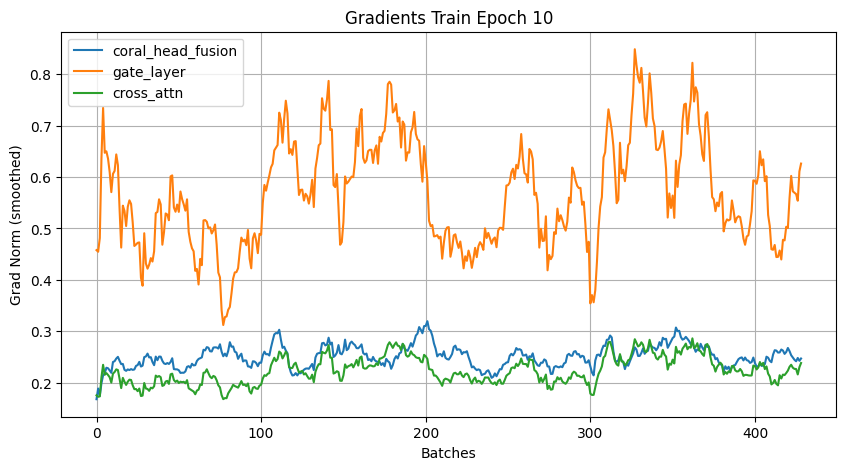

/tmp/ipykernel_36/1386669797.py:116: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 10/10 | Mode=fusion | Train Loss: 0.4777, Acc: 0.5450 | Val Loss: 0.5691, Acc: 0.4456, QWK: 0.4088
GradMonitor
coral_head_fusion
coral_head_fusion len: 108 [0.20130311464890838, 0.25646239169873297, 0.24841398388768235, 0.2983891422627494, 0.2648930695373565, 0.24240805771357068, 0.24659547366068832, 0.24137991762836464, 0.24164481561941406, 0.25020909633021804, 0.2819283818593249, 0.28434193136636166, 0.2819432985270396, 0.28235371636692436, 0.26215594469103964, 0.2720720853190869, 0.28886055792681875, 0.28763863826170566, 0.2908046612981707, 0.30211001094430684]
gate_layer
gate_layer len: 108 [0.763053834438324, 0.7842319011688232, 0.7598281502723694, 0.8593712598085403, 0.751995462179184, 0.6931846042474111, 0.6755298716681344, 0.6612714603543282, 0.6310044593281217, 0.6208510816097259, 0.706627482175827, 0.6609161615371704, 0.6645653724670411, 0.6300014555454254, 0.5556641697883606, 0.5623092263936996, 0.622138261795044, 0.5788558095693588, 0.5578426122665405, 0.5743992984294

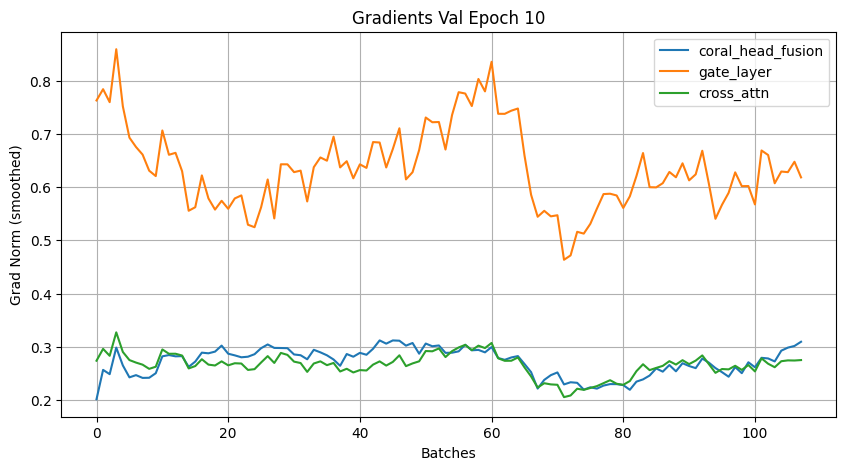

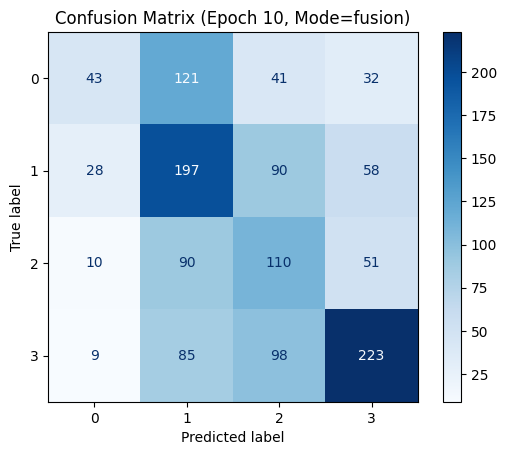

cm [[ 43 121  41  32]
 [ 28 197  90  58]
 [ 10  90 110  51]
 [  9  85  98 223]]
Group 0 LR: 2.5e-05


Epoch 11/20 (fusion):   0%|          | 0/429 [00:00<?, ?it/s]/tmp/ipykernel_36/1386669797.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 11/20 (fusion): 100%|██████████| 429/429 [19:42<00:00,  2.76s/it, loss=0.813, acc=0.563] 

GradMonitor
coral_head_fusion
coral_head_fusion len: 429 [0.2778494288213551, 0.23914967174641788, 0.23305773998921117, 0.25807810958940536, 0.23800646292511374, 0.2376526227259698, 0.24915025950342948, 0.2522815640695626, 0.2431217970766334, 0.2386587445740588, 0.26298997645499184, 0.25497104331152515, 0.25376629453385247, 0.25775678154313936, 0.24399496858241038, 0.2501732725650072, 0.2567752057220787, 0.24344916879199446, 0.23323541316203772, 0.24372458979487419]
gate_layer
gate_layer len: 429 [0.436306357383728, 0.3441128805279732, 0.38224758207798004, 0.3849984221160412, 0.36647134721279145, 0.37534799923499423, 0.3994079551526478, 0.4171354677528143, 0.474146768450737, 0.48171483129262926, 0.5311136350035668, 0.5111898362636567, 0.5290792599320412, 0.5291850998997688, 0.5221643880009651, 0.5362742230296135, 0.5366951629519463, 0.5048575788736344, 0.4830403357744217, 0.4527484506368637]
cross_attn
cross_attn len: 429 [0.20198315219022334, 0.1641474481439218, 0.17906106872639307, 0

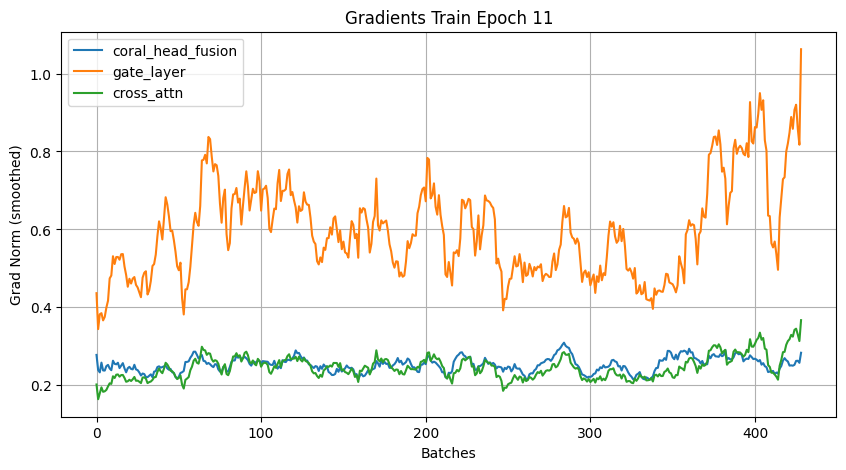

/tmp/ipykernel_36/1386669797.py:116: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 11/10 | Mode=fusion | Train Loss: 0.4647, Acc: 0.5635 | Val Loss: 0.5865, Acc: 0.4533, QWK: 0.4027
GradMonitor
coral_head_fusion
coral_head_fusion len: 108 [0.14188284543342888, 0.2570865369634703, 0.26914382438796264, 0.29865873692324385, 0.26314565087668595, 0.24027464305981994, 0.2546808582597545, 0.2400339493760839, 0.24445872257153192, 0.2624210429377854, 0.3055290228687227, 0.3152553412364796, 0.31290125523228196, 0.304518187395297, 0.29348832129035146, 0.30688261359464375, 0.331554331863299, 0.3232657968532294, 0.3404150094371289, 0.34260123297572137]
gate_layer
gate_layer len: 108 [0.3886519968509674, 0.8865673691034317, 0.933503121137619, 1.0020673349499702, 0.9627869904041291, 0.8963382790486017, 0.8401163859026772, 0.799584548920393, 0.7701585723294152, 0.7253384679555893, 0.8327567189931869, 0.8573782980442047, 0.8350054442882537, 0.7865916907787323, 0.7088040262460709, 0.6768079191446305, 0.7264657109975815, 0.7366691559553147, 0.7454257518053055, 0.7666748374700546]

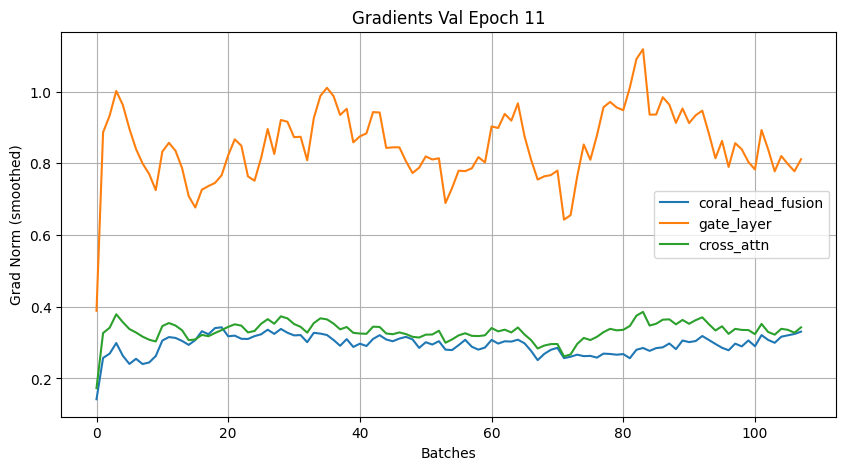

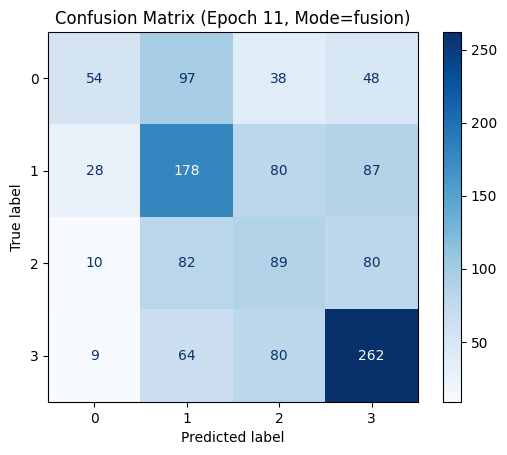

cm [[ 54  97  38  48]
 [ 28 178  80  87]
 [ 10  82  89  80]
 [  9  64  80 262]]
Group 0 LR: 2.5e-05


Epoch 12/20 (fusion):   0%|          | 0/429 [00:00<?, ?it/s]/tmp/ipykernel_36/1386669797.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 12/20 (fusion): 100%|██████████| 429/429 [18:22<00:00,  2.57s/it, loss=0.485, acc=0.558]

GradMonitor
coral_head_fusion
coral_head_fusion len: 429 [0.1985052323434502, 0.17891467385925353, 0.23387387689823905, 0.2261570078553632, 0.2166245342232287, 0.21892438285673657, 0.21776044854362095, 0.221284459636081, 0.2132151167218884, 0.21362576158717275, 0.24880007216706873, 0.24635067933704705, 0.2606448643375188, 0.24825208224356174, 0.2618532259017229, 0.2702577141113579, 0.2717530035879463, 0.28319521113298834, 0.2853357993531972, 0.29049441060051323]
gate_layer
gate_layer len: 429 [0.4636044502258301, 0.2731054909527302, 0.4059751555323601, 0.41553551889956, 0.3809883579611778, 0.3873300241927306, 0.4396608972123691, 0.44979800190776587, 0.4386380571458075, 0.4889767996966839, 0.5923346094787121, 0.5955337516963481, 0.7129246488213539, 0.7259019747376442, 0.7450332894921303, 0.7961310625076294, 0.8229224860668183, 0.7965279519557953, 0.803588205575943, 0.8214697360992431]
cross_attn
cross_attn len: 429 [0.20839536259882152, 0.14793846069369465, 0.20078492312071225, 0.194647

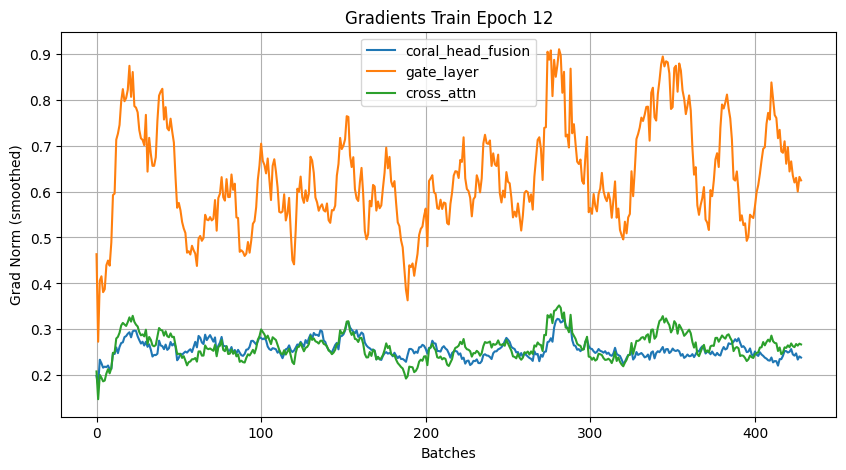

/tmp/ipykernel_36/1386669797.py:116: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 12/10 | Mode=fusion | Train Loss: 0.4717, Acc: 0.5582 | Val Loss: 0.5895, Acc: 0.4588, QWK: 0.4151
GradMonitor
coral_head_fusion
coral_head_fusion len: 108 [0.14170536468736827, 0.2624583797296509, 0.27420634411585826, 0.3076548907556571, 0.2727002679370344, 0.24938311466636756, 0.26788928459531497, 0.256589847849682, 0.2604902441509896, 0.2735518335364759, 0.31057054856792093, 0.32291058080736545, 0.31808743488509206, 0.3115933899069205, 0.30258389173541217, 0.3165026461239904, 0.3403801632579416, 0.3257968109101057, 0.33503457750193777, 0.3352705614175647]
gate_layer
gate_layer len: 108 [0.4535176455974579, 0.9315777271986008, 1.0971024334430695, 1.1597300991415977, 1.1062630593776703, 1.0287110259135563, 0.9798159045832497, 0.93241161480546, 0.9039193756050534, 0.8843450874090195, 1.0144860118627548, 1.0834627628326416, 1.089953601360321, 0.9994059920310974, 0.9048499196767807, 0.8769698470830918, 0.9427067786455154, 0.9241053611040115, 0.9431193917989731, 0.9434667378664017]


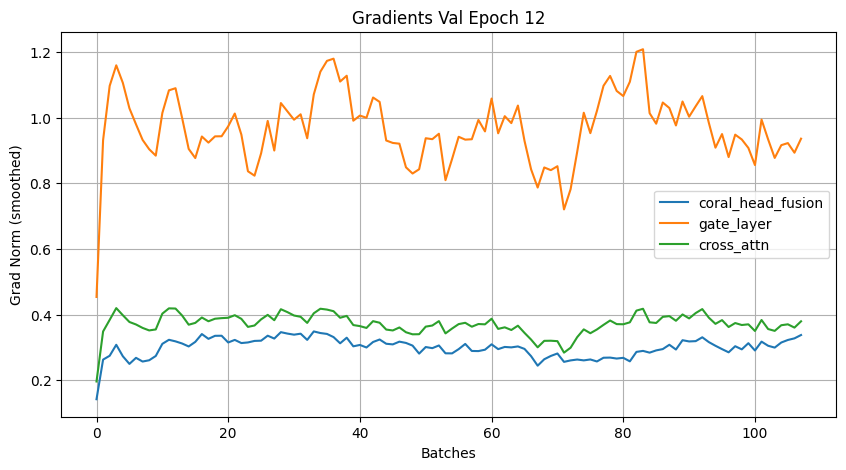

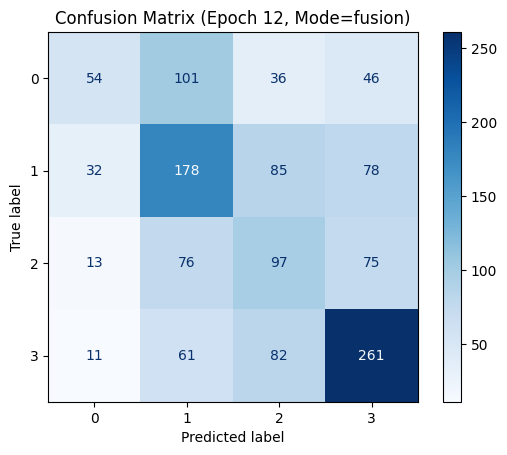

cm [[ 54 101  36  46]
 [ 32 178  85  78]
 [ 13  76  97  75]
 [ 11  61  82 261]]
Group 0 LR: 1.25e-05


Epoch 13/20 (fusion):   0%|          | 0/429 [00:00<?, ?it/s]/tmp/ipykernel_36/1386669797.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 13/20 (fusion): 100%|██████████| 429/429 [18:30<00:00,  2.59s/it, loss=0.404, acc=0.57] 

GradMonitor
coral_head_fusion
coral_head_fusion len: 429 [0.3179426211863756, 0.24890747293829918, 0.22659171605482697, 0.22182190557941794, 0.20321280327625574, 0.19635591675372174, 0.20858355681411922, 0.20938231688342057, 0.21349044508921602, 0.21743153997231274, 0.23643012398388236, 0.22432747066486627, 0.24597491624299436, 0.2519785566953942, 0.25340039425063876, 0.2547230249736458, 0.2602192756719887, 0.24685136277694256, 0.24124197668861597, 0.23741981650236993]
gate_layer
gate_layer len: 429 [0.9898349642753601, 0.8259760439395905, 0.8447530666987101, 0.7810987681150436, 0.73307204246521, 0.6654934138059616, 0.6794258398669106, 0.6298709772527218, 0.6048641900221506, 0.6324637204408645, 0.6823856830596924, 0.659564220905304, 0.6779804110527039, 0.6734666585922241, 0.6576884001493454, 0.6448821425437927, 0.6797212094068528, 0.6234807223081589, 0.6449782967567443, 0.6674838185310363]
cross_attn
cross_attn len: 429 [0.3812644178979099, 0.32026198657695204, 0.3003000730338196, 0.28

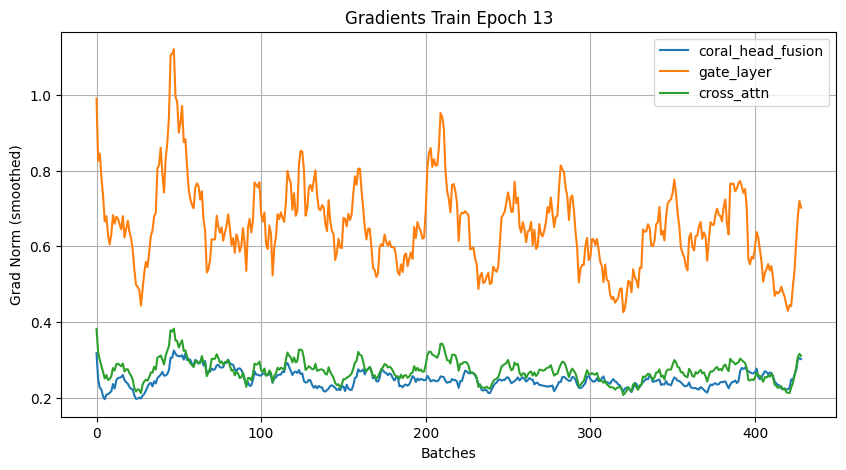

/tmp/ipykernel_36/1386669797.py:116: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 13/10 | Mode=fusion | Train Loss: 0.4621, Acc: 0.5701 | Val Loss: 0.5853, Acc: 0.4533, QWK: 0.4181
GradMonitor
coral_head_fusion
coral_head_fusion len: 108 [0.20329422829672694, 0.2501821976620704, 0.25987088136995834, 0.3177727864822373, 0.279959870595485, 0.26030819754426676, 0.2638522904100163, 0.260464905295521, 0.2601023294652502, 0.2691922158468515, 0.303960690414533, 0.3117963605094701, 0.3089244381058961, 0.3075434274971485, 0.2875553448218852, 0.2992103752680123, 0.31667846334166827, 0.3084921837318689, 0.30736117260530593, 0.3215322867035866]
gate_layer
gate_layer len: 108 [0.9681514501571655, 1.0257230997085571, 1.0774633089701335, 1.1754227876663208, 1.0442384123802184, 0.9602157274881998, 0.9273287739072528, 0.9140993803739548, 0.8697661989265018, 0.8295524418354034, 0.9470496356487275, 0.9060590028762817, 0.921981406211853, 0.8518863320350647, 0.7605881989002228, 0.7630615353584289, 0.8091836154460907, 0.7526708319783211, 0.734229888021946, 0.7767836317420006]
cross

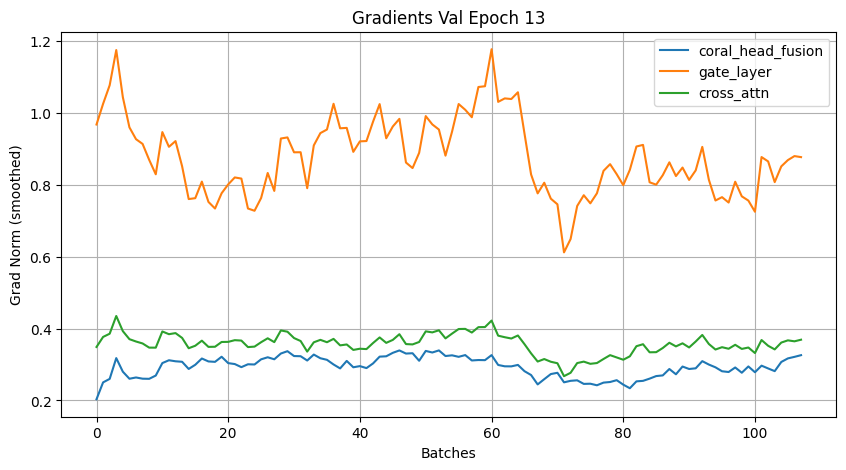

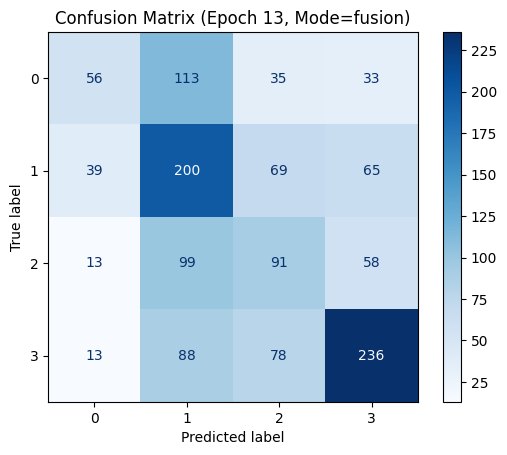

cm [[ 56 113  35  33]
 [ 39 200  69  65]
 [ 13  99  91  58]
 [ 13  88  78 236]]
Group 0 LR: 1.25e-05


Epoch 14/20 (fusion):   0%|          | 0/429 [00:00<?, ?it/s]/tmp/ipykernel_36/1386669797.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 14/20 (fusion): 100%|██████████| 429/429 [20:58<00:00,  2.93s/it, loss=0.394, acc=0.574] 

GradMonitor
coral_head_fusion
coral_head_fusion len: 429 [0.1532944943755865, 0.23443607427179813, 0.2734664920717478, 0.2761898632161319, 0.26508842427283524, 0.2502850778400898, 0.2431308730904545, 0.23271727800602093, 0.23466399943249094, 0.2286121178884059, 0.2438267874531448, 0.2532606130931526, 0.2439920655451715, 0.22361328869592398, 0.21057683448307216, 0.23058408829383553, 0.2299170267302543, 0.22678773945663125, 0.23060629407409577, 0.22148270735051484]
gate_layer
gate_layer len: 429 [0.4399019479751587, 0.9502700567245483, 0.9016724626223246, 0.7324048578739166, 0.6250080913305283, 0.6085392609238625, 0.5796660972493035, 0.549594996497035, 0.540717696150144, 0.5330505326390267, 0.575338576734066, 0.5822719380259513, 0.5528618976473808, 0.4904520228505135, 0.5018493309617043, 0.5245590090751648, 0.5166987717151642, 0.5320474833250046, 0.5889432847499847, 0.5835615456104278]
cross_attn
cross_attn len: 429 [0.1704995137406513, 0.305835081206169, 0.3010484059729303, 0.2737043297

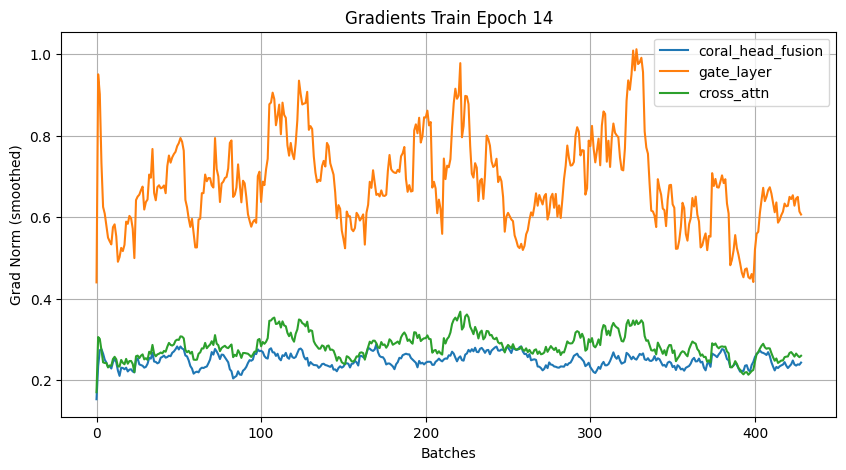

/tmp/ipykernel_36/1386669797.py:116: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 14/10 | Mode=fusion | Train Loss: 0.4555, Acc: 0.5740 | Val Loss: 0.5811, Acc: 0.4409, QWK: 0.4264
GradMonitor
coral_head_fusion
coral_head_fusion len: 108 [0.22180105559527874, 0.2548193163238466, 0.25185157886395854, 0.3159687293227762, 0.28133233995176854, 0.268647527283368, 0.2682031531751688, 0.2678475075226743, 0.2658806185289804, 0.27204857252072545, 0.30202117830049247, 0.3066737595247105, 0.30156959819141776, 0.30551343664992603, 0.2815273317275569, 0.2919137956574559, 0.3033541651442647, 0.2991486488841474, 0.2943873876705766, 0.31041092122904956]
gate_layer
gate_layer len: 108 [0.9897665977478027, 0.9459016025066376, 0.9320974151293436, 1.0749027580022812, 0.9482758581638336, 0.8968473722537359, 0.8721401308264051, 0.8719621561467648, 0.8234135939015282, 0.7931945353746415, 0.8702110141515732, 0.8103812575340271, 0.8142796635627747, 0.7680259883403778, 0.6757874727249146, 0.6892403334379196, 0.7336314171552658, 0.688014206290245, 0.6551329284906388, 0.7049085646867752]

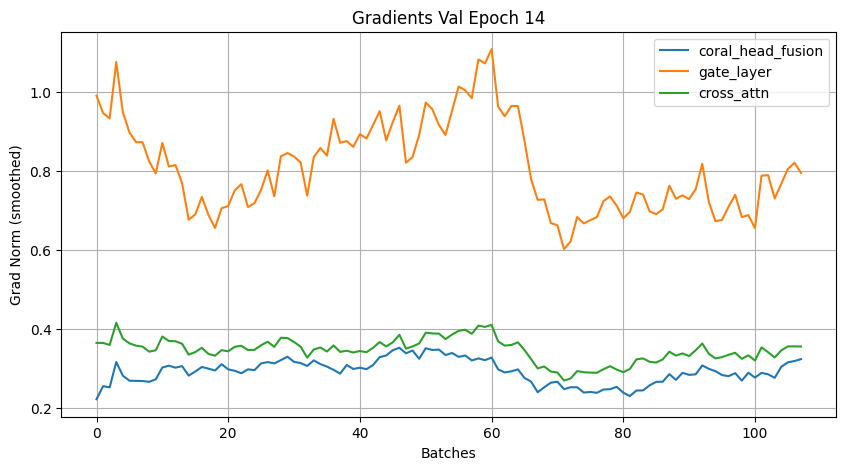

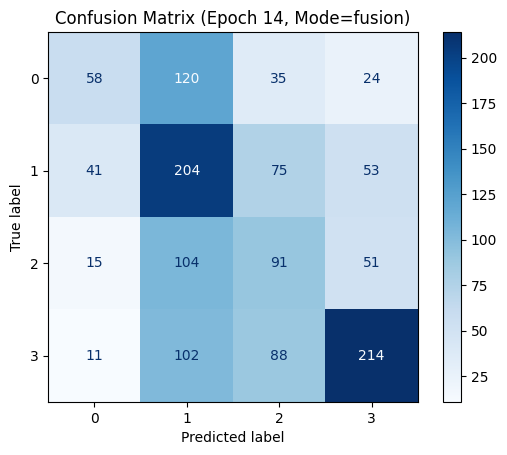

cm [[ 58 120  35  24]
 [ 41 204  75  53]
 [ 15 104  91  51]
 [ 11 102  88 214]]
Group 0 LR: 1.25e-05


Epoch 15/20 (fusion):   0%|          | 0/429 [00:00<?, ?it/s]/tmp/ipykernel_36/1386669797.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 15/20 (fusion): 100%|██████████| 429/429 [21:38<00:00,  3.03s/it, loss=0.448, acc=0.583]

GradMonitor
coral_head_fusion
coral_head_fusion len: 429 [0.22302090330049396, 0.28611286147497594, 0.2854591494736572, 0.25734305707737803, 0.2419031510129571, 0.2350622205218921, 0.22705566929653287, 0.2218154268921353, 0.22444819602080518, 0.23003944186493755, 0.25857406412251294, 0.258512483490631, 0.2416201513260603, 0.23706683861091732, 0.2422476983629167, 0.24250519184861333, 0.242801354941912, 0.24501064077485352, 0.24594740129541606, 0.24577316956128925]
gate_layer
gate_layer len: 429 [0.31973904371261597, 0.418884813785553, 0.43935563166936237, 0.4075402319431305, 0.4533054709434509, 0.5181728502114614, 0.5019730244364057, 0.46756454184651375, 0.45567132698165047, 0.4747191101312637, 0.511126247048378, 0.5327588349580765, 0.5535955339670181, 0.5696003526449204, 0.5896683692932129, 0.560272616147995, 0.5193470120429993, 0.5304966390132904, 0.560074844956398, 0.619698503613472]
cross_attn
cross_attn len: 429 [0.1557057510362938, 0.2279971581301652, 0.22835896909236908, 0.206390

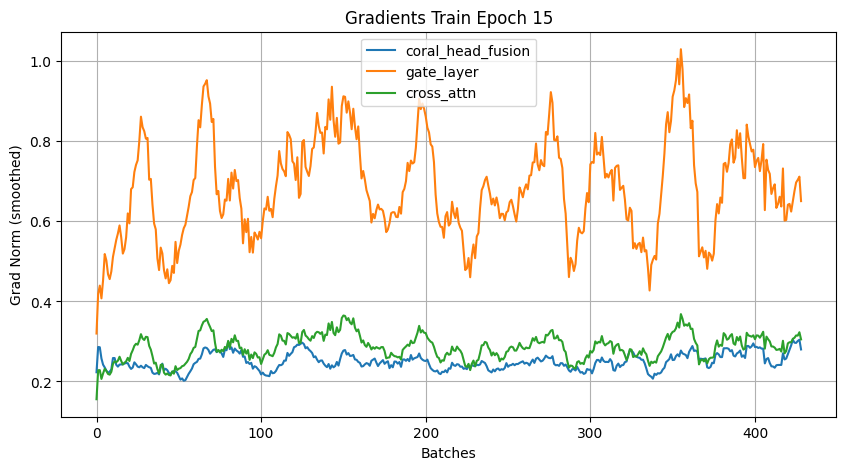

/tmp/ipykernel_36/1386669797.py:116: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 15/10 | Mode=fusion | Train Loss: 0.4535, Acc: 0.5829 | Val Loss: 0.5804, Acc: 0.4463, QWK: 0.4249
GradMonitor
coral_head_fusion
coral_head_fusion len: 108 [0.2124960063956678, 0.25999704212881625, 0.2500048015887539, 0.31592569779604673, 0.28083923696540297, 0.27213932973487925, 0.2738784463477454, 0.2733974626462441, 0.27135432296846473, 0.27636940439697355, 0.3065914051840082, 0.3116926559479907, 0.30583267721813173, 0.31031016681808976, 0.2857154230354354, 0.29589008055627347, 0.3060451025143266, 0.29934911699965594, 0.29446452306583526, 0.3078915756661445]
gate_layer
gate_layer len: 108 [0.8875488042831421, 0.9893607497215271, 0.9582468271255493, 1.078559696674347, 0.9542489528656006, 0.9049753546714783, 0.8724234359604972, 0.8582789227366447, 0.8175289001729753, 0.7828217297792435, 0.8603875786066055, 0.8209913551807404, 0.8134921431541443, 0.7668796688318252, 0.6769288212060929, 0.6834312468767166, 0.7205941647291183, 0.677889022231102, 0.6553896576166153, 0.69606782197952

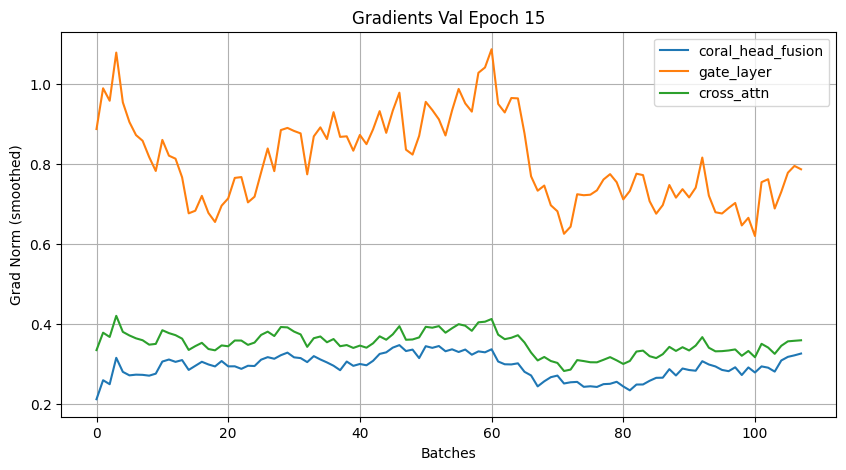

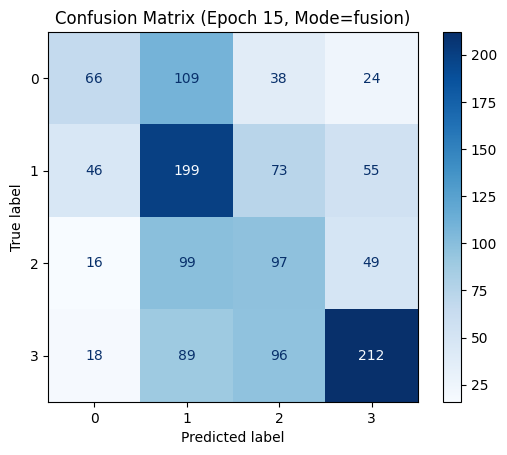

cm [[ 66 109  38  24]
 [ 46 199  73  55]
 [ 16  99  97  49]
 [ 18  89  96 212]]
Group 0 LR: 6.25e-06


Epoch 16/20 (fusion):   0%|          | 0/429 [00:00<?, ?it/s]/tmp/ipykernel_36/1386669797.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 16/20 (fusion): 100%|██████████| 429/429 [20:52<00:00,  2.92s/it, loss=0.613, acc=0.571]

GradMonitor
coral_head_fusion
coral_head_fusion len: 429 [0.4282027976587415, 0.32917019724845886, 0.2661694396908085, 0.26303925970569253, 0.243062471691519, 0.24770832426535586, 0.24968345968851022, 0.24440702481660992, 0.2447109154632522, 0.24630480003543198, 0.27654759283177555, 0.25872512753121557, 0.26502444096840916, 0.2737416706047952, 0.2722988914698362, 0.2812738684471697, 0.2763528998941183, 0.27311800024472177, 0.2832825148012489, 0.277604917017743]
gate_layer
gate_layer len: 429 [1.3111547231674194, 1.2335626482963562, 0.887991284330686, 0.9019546769559383, 0.8019061893224716, 0.8283262625336647, 0.8703356449093137, 0.794990511611104, 0.7745195047722923, 0.8148804500699043, 0.8801079526543617, 0.7835378751158715, 0.7000111922621727, 0.6928389549255372, 0.6403412342071533, 0.6633433043956757, 0.6225688934326172, 0.5291323006153107, 0.5667162209749221, 0.5931864708662034]
cross_attn
cross_attn len: 429 [0.5161724993959069, 0.4577486604684964, 0.3487782065058127, 0.3487152223

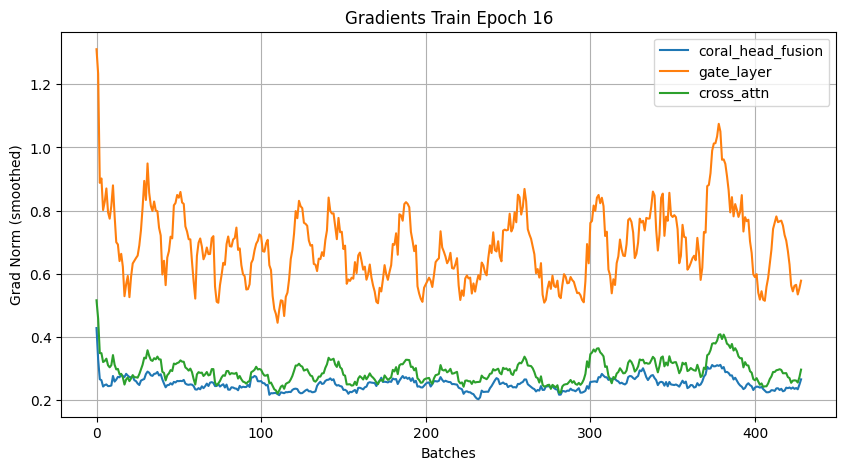

/tmp/ipykernel_36/1386669797.py:116: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 16/10 | Mode=fusion | Train Loss: 0.4581, Acc: 0.5714 | Val Loss: 0.5854, Acc: 0.4549, QWK: 0.4128
GradMonitor
coral_head_fusion
coral_head_fusion len: 108 [0.21143458411097527, 0.26053287414833903, 0.25383363633106154, 0.3096164499875158, 0.27446844545193017, 0.26053817907813936, 0.2644231481411095, 0.2593404331419151, 0.2597494488323314, 0.26593046945054083, 0.29858104980085043, 0.30539851111825556, 0.3022386714583263, 0.3035396886756644, 0.28332820350769905, 0.2938003726769239, 0.30812905691564085, 0.29991990188136697, 0.30120664844289424, 0.3132401212118566]
gate_layer
gate_layer len: 108 [0.9197918772697449, 1.0307097136974335, 1.0153480966885884, 1.130562350153923, 1.0176249027252198, 0.95341357588768, 0.9172622391155788, 0.8970910087227821, 0.8512916399372948, 0.8180260747671128, 0.918429383635521, 0.8713999897241592, 0.8684638172388077, 0.8163163483142852, 0.7338724970817566, 0.7341903328895569, 0.77330202460289, 0.7210589617490768, 0.7037042289972305, 0.7585855960845947]

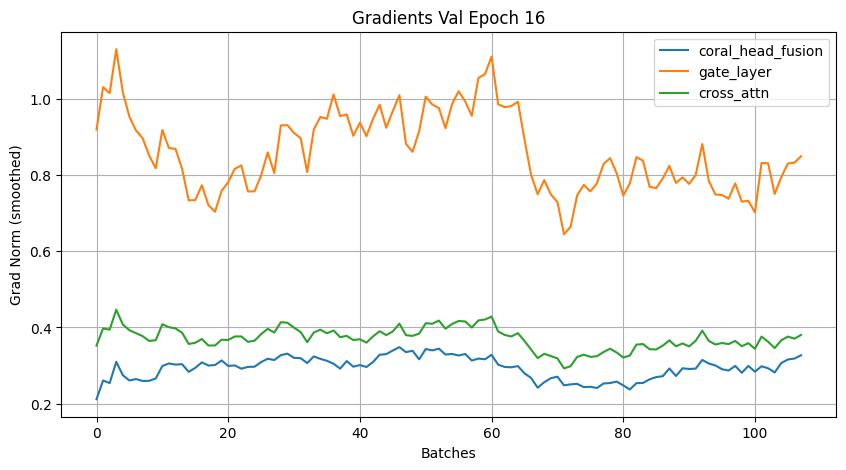

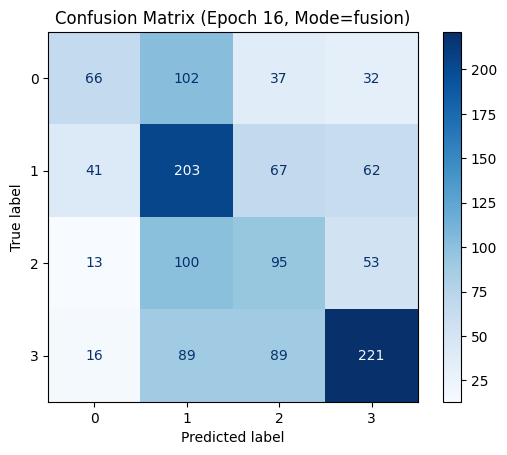

cm [[ 66 102  37  32]
 [ 41 203  67  62]
 [ 13 100  95  53]
 [ 16  89  89 221]]
Group 0 LR: 6.25e-06


Epoch 17/20 (fusion):   0%|          | 0/429 [00:00<?, ?it/s]/tmp/ipykernel_36/1386669797.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 17/20 (fusion): 100%|██████████| 429/429 [21:39<00:00,  3.03s/it, loss=0.504, acc=0.547] 

GradMonitor
coral_head_fusion
coral_head_fusion len: 429 [0.1947386641986668, 0.20823046145960689, 0.21849569460997978, 0.2260106175672263, 0.21803042003884912, 0.21809143460510919, 0.22140397766738065, 0.22195450964500196, 0.22533758261447978, 0.2224867604440078, 0.23836471016984434, 0.24503759338986128, 0.24143685984890909, 0.23730115599464624, 0.23743259317707271, 0.23921222265344114, 0.23930706921964884, 0.23047435898333787, 0.2305577167775482, 0.22918295837007463]
gate_layer
gate_layer len: 429 [0.38028717041015625, 0.43558646738529205, 0.5981303155422211, 0.5759381055831909, 0.5994985103607178, 0.6200143198172251, 0.6320630482264927, 0.6660524979233742, 0.6767844491534762, 0.6818043768405915, 0.7540282905101776, 0.7777222335338593, 0.8085527747869492, 0.7652898669242859, 0.7622588366270066, 0.7759476274251937, 0.7505709648132324, 0.7385752260684967, 0.705487996339798, 0.6733166545629501]
cross_attn
cross_attn len: 429 [0.16817647975403816, 0.2157265460700728, 0.23646481214867285,

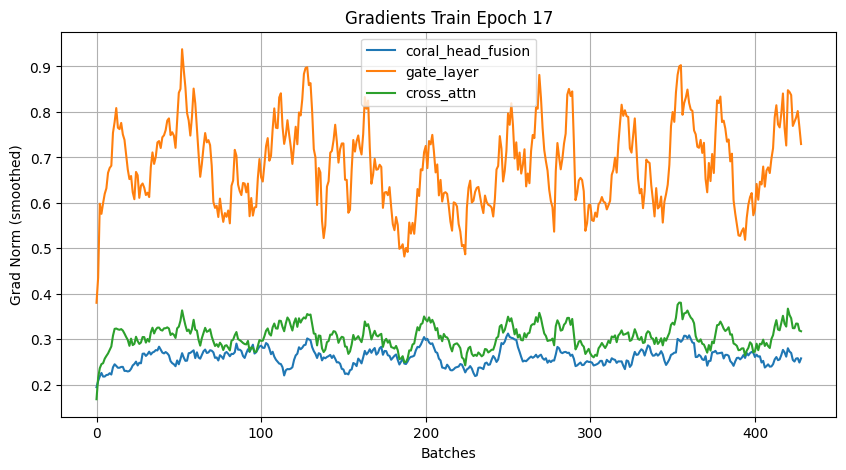

/tmp/ipykernel_36/1386669797.py:116: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 17/10 | Mode=fusion | Train Loss: 0.4730, Acc: 0.5466 | Val Loss: 0.5767, Acc: 0.4456, QWK: 0.4130
GradMonitor
coral_head_fusion
coral_head_fusion len: 108 [0.19218785408884287, 0.25885714683681726, 0.2539422904762129, 0.29538138082716614, 0.26112563204951583, 0.24327368029238036, 0.2505515220774604, 0.24455913572455756, 0.24681619164119992, 0.25404084029141816, 0.28301233497913925, 0.29011823071632536, 0.2867967169964686, 0.2880932898959145, 0.27159526247996835, 0.28456422830931843, 0.30149222663603725, 0.2971193959470838, 0.29978593876585363, 0.3073369357269257]
gate_layer
gate_layer len: 108 [0.6933932900428772, 0.8953069746494293, 0.9497083226839701, 1.0569556504487991, 0.9738919973373413, 0.9016047914822897, 0.8563286406653268, 0.826850987970829, 0.7839151521523794, 0.75021792948246, 0.8308805495500564, 0.8146041601896286, 0.8190888971090317, 0.7560187548398971, 0.6667377561330795, 0.6510989516973495, 0.6956160634756088, 0.6509648382663726, 0.6429541170597076, 0.690497079491

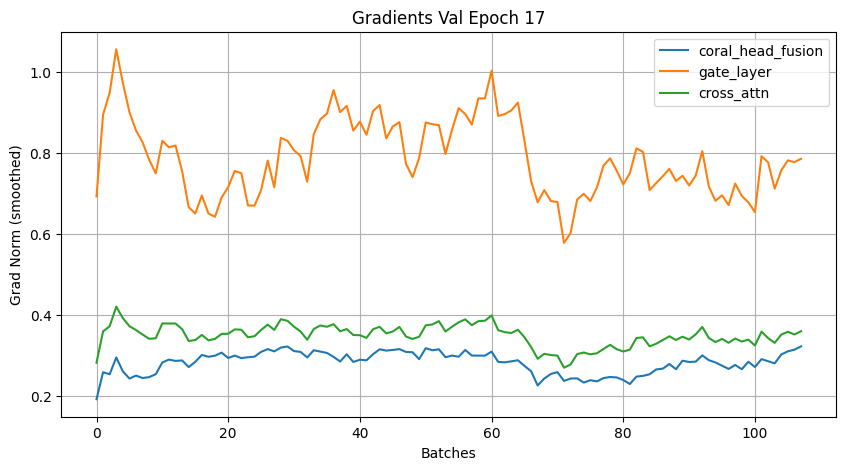

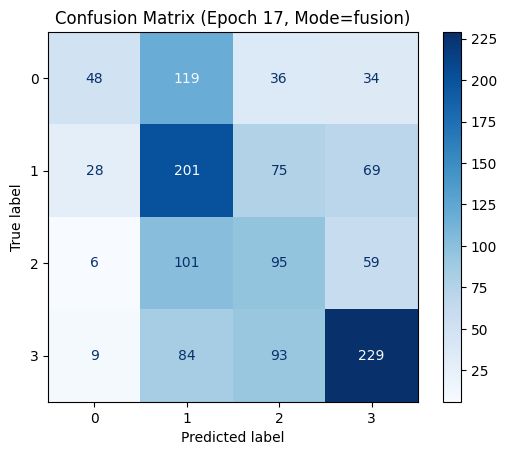

cm [[ 48 119  36  34]
 [ 28 201  75  69]
 [  6 101  95  59]
 [  9  84  93 229]]
Group 0 LR: 6.25e-06


Epoch 18/20 (fusion):   0%|          | 0/429 [00:00<?, ?it/s]/tmp/ipykernel_36/1386669797.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 18/20 (fusion): 100%|██████████| 429/429 [22:37<00:00,  3.16s/it, loss=0.478, acc=0.544] 

GradMonitor
coral_head_fusion
coral_head_fusion len: 429 [0.28148022666573524, 0.25538915675133467, 0.2566378900470833, 0.24218772002495825, 0.24871034966781735, 0.23443086398765445, 0.23099388341818536, 0.23712644597981125, 0.23967778941409457, 0.24254523939453065, 0.26677320222370327, 0.2631453288719058, 0.2652348651085049, 0.26729858480393887, 0.26248800053726884, 0.25500326526816935, 0.25917768080253156, 0.25531982274260373, 0.26025201331358405, 0.2526028823805973]
gate_layer
gate_layer len: 429 [0.9918908476829529, 0.653631404042244, 0.5538776914278666, 0.6490663290023804, 0.6414611101150512, 0.5734007135033607, 0.5604277870484761, 0.6492247451096773, 0.6025701827473111, 0.569676598906517, 0.6177216440439224, 0.5752501219511033, 0.612034273147583, 0.6350121051073074, 0.5814163982868195, 0.5605551391839981, 0.5795756116509437, 0.557584585249424, 0.4721603348851204, 0.4766468346118927]
cross_attn
cross_attn len: 429 [0.38409466785378754, 0.2931994245154783, 0.27437118828917545, 0.28

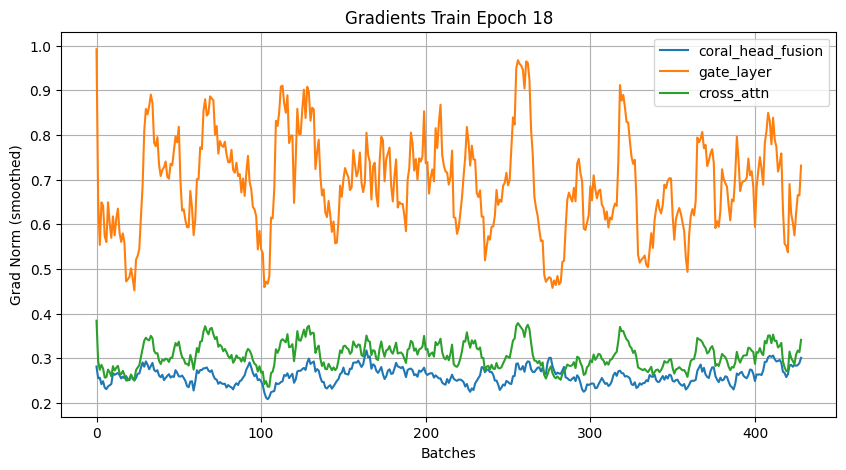

/tmp/ipykernel_36/1386669797.py:116: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 18/10 | Mode=fusion | Train Loss: 0.4752, Acc: 0.5438 | Val Loss: 0.5736, Acc: 0.4471, QWK: 0.4245
GradMonitor
coral_head_fusion
coral_head_fusion len: 108 [0.19179130485281348, 0.24905239627696574, 0.24122687056660652, 0.2892695569898933, 0.2581563977524638, 0.2432753413449973, 0.24901221293423856, 0.245653702004347, 0.24707281796468628, 0.2520752102136612, 0.27879870566539466, 0.28458065311424435, 0.2809969787951559, 0.28366438653320075, 0.26519329408183695, 0.2760387779213488, 0.2903652668464929, 0.2847001466434449, 0.2840646508615464, 0.2933969388715923]
gate_layer
gate_layer len: 108 [0.6952917575836182, 0.8182091414928436, 0.8452293674151102, 0.9945576936006546, 0.8949679255485534, 0.8353651066621145, 0.801764862877982, 0.7760540246963501, 0.7343561814890968, 0.706932321190834, 0.7739972084760666, 0.7487306952476501, 0.7576250791549682, 0.7070155322551728, 0.610126280784607, 0.607632976770401, 0.6451947748661041, 0.6055769592523574, 0.5980331689119339, 0.6440781950950623]
c

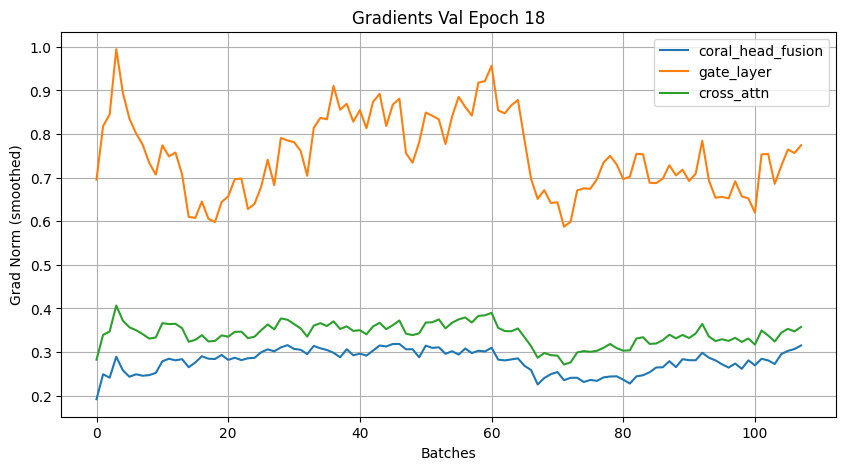

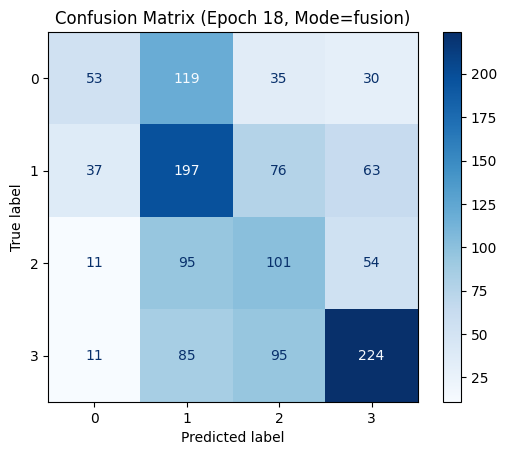

cm [[ 53 119  35  30]
 [ 37 197  76  63]
 [ 11  95 101  54]
 [ 11  85  95 224]]
Group 0 LR: 3.125e-06


Epoch 19/20 (fusion):   0%|          | 0/429 [00:00<?, ?it/s]/tmp/ipykernel_36/1386669797.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 19/20 (fusion): 100%|██████████| 429/429 [21:14<00:00,  2.97s/it, loss=0.553, acc=0.561] 

GradMonitor
coral_head_fusion
coral_head_fusion len: 429 [0.27769075334072113, 0.2259354591369629, 0.22888375213369727, 0.2208880748366937, 0.21021858556196094, 0.20742858201265335, 0.21103699751464383, 0.2315249652019702, 0.22537308750260207, 0.23529624049551784, 0.2619034850969911, 0.25396238337270916, 0.2549230193719268, 0.2490978616522625, 0.24909182914998382, 0.26471857118885966, 0.2698943213792518, 0.2784457271685824, 0.2652600144734606, 0.26750923797953874]
gate_layer
gate_layer len: 429 [0.9456462264060974, 0.5731494873762131, 0.5788334111372629, 0.5164021104574203, 0.43953455686569215, 0.41952504217624664, 0.48345636895724703, 0.4964062012732029, 0.473570575316747, 0.46826800107955935, 0.5020043313503265, 0.4707765460014343, 0.514106497168541, 0.4904903471469879, 0.50763199031353, 0.6442233890295028, 0.628765843808651, 0.6298444613814353, 0.59263766258955, 0.6061830565333366]
cross_attn
cross_attn len: 429 [0.36545932828448713, 0.24177279803552665, 0.2515231298942429, 0.233802

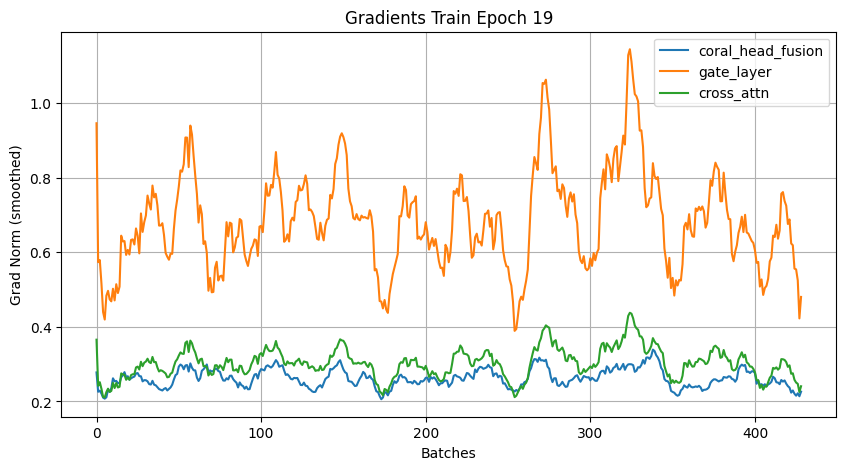

/tmp/ipykernel_36/1386669797.py:116: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 19/10 | Mode=fusion | Train Loss: 0.4690, Acc: 0.5611 | Val Loss: 0.5760, Acc: 0.4518, QWK: 0.4262
GradMonitor
coral_head_fusion
coral_head_fusion len: 108 [0.19225276354700327, 0.24622258264571428, 0.24754334691291055, 0.3030208124546334, 0.2684733397793025, 0.2544205714560424, 0.25807484043096857, 0.2551365516555961, 0.2556176676880568, 0.2609569052932784, 0.2901813687523827, 0.29890644329134375, 0.294329377100803, 0.2968348822789267, 0.2749513345072046, 0.2860321675427258, 0.2997898768633604, 0.29362776344642044, 0.2915586240589619, 0.3040098974481225]
gate_layer
gate_layer len: 108 [0.7691516280174255, 0.9010267853736877, 0.9285662968953451, 1.082264244556427, 0.969207501411438, 0.9033348460992178, 0.8639443857329232, 0.8437864184379578, 0.7931501401795281, 0.7618420988321304, 0.8390158265829086, 0.8181242257356643, 0.822340676188469, 0.7633933246135711, 0.6566615283489228, 0.6555059641599655, 0.6955462664365768, 0.6516897842288017, 0.6397278115153313, 0.6954448744654655]
cro

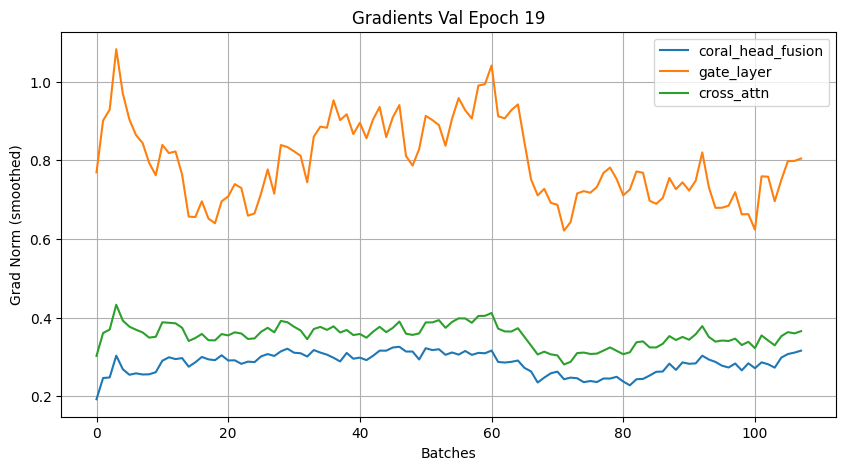

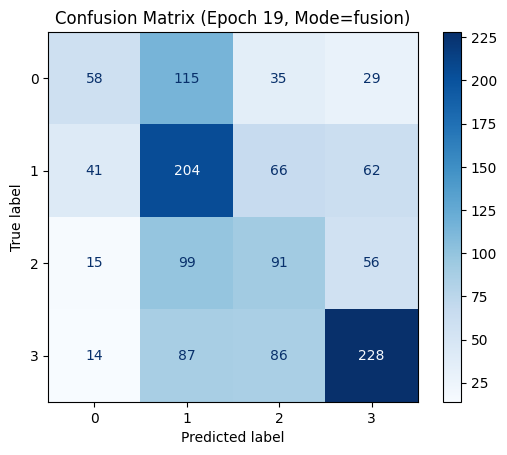

cm [[ 58 115  35  29]
 [ 41 204  66  62]
 [ 15  99  91  56]
 [ 14  87  86 228]]
Group 0 LR: 3.125e-06


In [26]:
from torch.utils.data import random_split, DataLoader
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import random
from coral_pytorch.dataset import proba_to_label
import nltk
# основной теггер
nltk.download('averaged_perceptron_tagger_eng')

# для надёжности можно ещё:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

from sklearn.metrics import confusion_matrix as sk_confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ---------------- reproducibility ----------------
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)


# ---------------- Списки для хранения метрик ----------------
train_losses, val_losses = [], []
train_accs, val_accs = [], []
val_qwks = []

#grad_monitor = GradMonitor(model, layer_keywords=["coral_head_img", "img_encoder"])

# ---------------- Тренировка ----------------

for epoch in range(start_epoch, start_epoch+num_epochs):
    # --- Training ---
    model.train()
    model.set_mode(model_mode)   # 🔹 переключаем режим модели
    running_loss, correct, total = 0.0, 0, 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{start_epoch+num_epochs} ({model_mode})")

    grad_monitor.clear()

    for batch in pbar:
        images = batch["images"].to(device)
        photo_idx = batch["photo_idx"].to(device)
        key_padding_mask = batch["image_key_padding_mask"].to(device)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            # 🔹 вызываем модель с учётом режима
            if model_mode == "img":
                logits = model(images, photo_idx, key_padding_mask, None, None)
            elif model_mode == "txt":
                logits = model(None, None, None, input_ids, attention_mask)
            elif model_mode == "fusion":
                logits = model(images, photo_idx, key_padding_mask, input_ids, attention_mask)
            else:
                raise ValueError(f"Неизвестный режим: {model_mode}")

            # преобразуем labels
            coral_targets = prepare_coral_targets(labels, num_classes, smoothing=0.1)
            loss = criterion(logits, coral_targets)

        # обычный backward
        loss.backward()        # вычисляем градиенты
        optimizer.step()       # обновляем веса
        optimizer.zero_grad()  # обнуляем градиенты перед следующим шагом

        #scaler.scale(loss).backward()
        #scaler.step(optimizer)
        #scaler.update()

        running_loss += loss.item() * images.size(0)

        # для CORAL вместо argmax:
        probas = torch.sigmoid(logits)
        preds = proba_to_label(probas).to(device)

        correct += (preds == labels).sum().item()
        total += labels.size(0)
        pbar.set_postfix({"loss": loss.item(), "acc": correct/total})

        grad_monitor.step()

    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    grad_monitor.plot(title=f"Gradients Train Epoch {epoch}")

    # --- Validation ---
    model.eval()

    grad_monitor.clear()

    all_preds, all_labels = [], []
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    #with torch.no_grad():
    for batch in val_loader:
        images = batch["images"].to(device)
        photo_idx = batch["photo_idx"].to(device)
        key_padding_mask = batch["image_key_padding_mask"].to(device)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            if model_mode == "img":
                logits = model(images, photo_idx, key_padding_mask, None, None)
            elif model_mode == "txt":
                logits = model(None, None, None, input_ids, attention_mask)
            elif model_mode == "fusion":
                logits = model(images, photo_idx, key_padding_mask, input_ids, attention_mask)
            else:
                raise ValueError(f"Неизвестный режим: {model_mode}")

            coral_targets = prepare_coral_targets(labels, num_classes, smoothing=0.1)
            loss = criterion(logits, coral_targets)

            loss.backward()  # 🔹 вычисляем градиенты

        probas = torch.sigmoid(logits)
        preds = proba_to_label(probas).to(device)

        val_running_loss += loss.item() * images.size(0)
        val_correct += (preds == labels).sum().item()
        val_total += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        grad_monitor.step()

    val_loss = val_running_loss / val_total
    val_acc = val_correct / val_total
    val_qwk = quadratic_weighted_kappa(all_labels, all_preds)

    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_qwks.append(val_qwk)

    print(f"Epoch {epoch}/{num_epochs} | Mode={model_mode} | "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, QWK: {val_qwk:.4f}")

    grad_monitor.plot(title=f"Gradients Val Epoch {epoch}")

    # --- Confusion Matrix ---
    cm = sk_confusion_matrix(all_labels, all_preds, labels=list(range(num_classes)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(num_classes)))
    disp.plot(cmap=plt.cm.Blues, values_format="d")
    plt.title(f"Confusion Matrix (Epoch {epoch}, Mode={model_mode})")
    plt.show()
    print('cm', cm)

    # --- Scheduler ---
    scheduler.step(val_qwk)
    for i, group in enumerate(optimizer.param_groups):
        print(f"Group {i} LR: {group['lr']}")
    # --- Save best ---
    if val_qwk > best_qwk:
        best_qwk = val_qwk
        torch.save({
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            #"scaler_state": scaler.state_dict(),
            "epoch": epoch,
            "best_qwk": best_qwk
        }, save_path)
        print(f"✅ Saved best model (QWK={best_qwk:.4f}) at epoch {epoch}")


In [20]:
print('train_losses',train_losses,'\n val_losses', val_losses)
print('train_accs',train_accs,'\n val_accs', val_accs)
print('val_qwks',val_qwks)

train_losses [0.5470425730891547, 0.5366207381726702, 0.5474237185525477, 0.5404572921661177, 0.5317780003255728, 0.5256271389065956, 0.5109469398812719, 0.50274429342142, 0.49889123870749513, 0.4900979246064456] 
 val_losses [0.5697596532931409, 0.5624953508840563, 0.5662781642532645, 0.577722071349899, 0.5598294610739867, 0.5577061235163112, 0.5630848163950314, 0.5609531514752152, 0.596648197429918, 0.5772374694584688]
train_accs [0.4180758017492711, 0.4509232264334305, 0.42973760932944605, 0.4435374149659864, 0.45403304178814385, 0.46122448979591835, 0.4932944606413994, 0.49620991253644314, 0.5109815354713314, 0.5265306122448979] 
 val_accs [0.41368584758942456, 0.42223950233281493, 0.432348367029549, 0.42923794712286156, 0.4416796267496112, 0.42223950233281493, 0.447900466562986, 0.4354587869362364, 0.3989113530326594, 0.4393468118195957]
val_qwks [0.3643840545049688, 0.38044630704205196, 0.40413379905800284, 0.3660522413235878, 0.38827936685999975, 0.3900049658354082, 0.4279666402

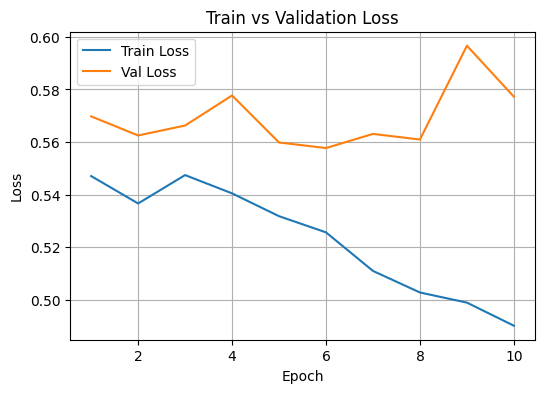

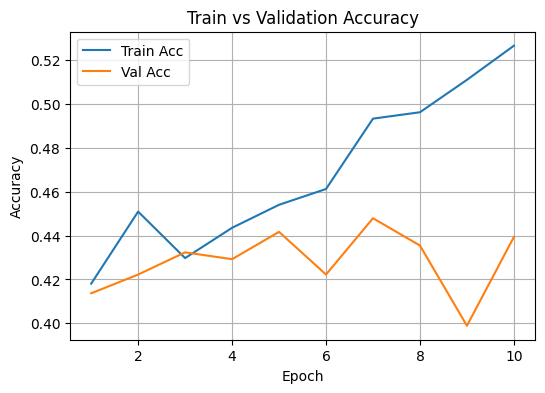

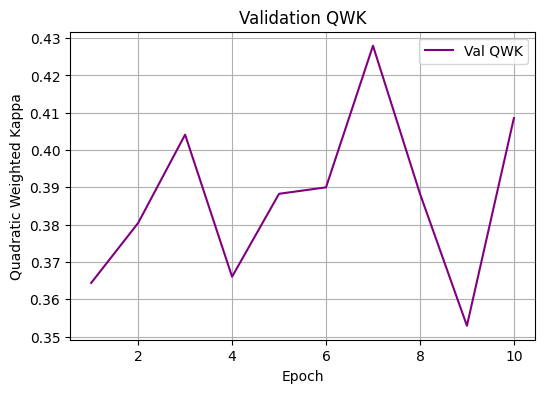

In [21]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

# --- 1. Loss ---
plt.figure(figsize=(6,4))
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# --- 2. Accuracy ---
plt.figure(figsize=(6,4))
plt.plot(epochs, train_accs, label="Train Acc")
plt.plot(epochs, val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# --- 3. QWK ---
plt.figure(figsize=(6,4))
plt.plot(epochs, val_qwks, label="Val QWK", color="purple")
plt.xlabel("Epoch")
plt.ylabel("Quadratic Weighted Kappa")
plt.title("Validation QWK")
plt.legend()
plt.grid(True)
plt.show()


In [22]:
from IPython.display import Audio, display
import numpy as np

# параметры звука
sr = 22050   # частота дискретизации
T = 2.0      # длительность (сек)
f = 440.0    # частота (Гц, "ля")

t = np.linspace(0, T, int(T*sr), endpoint=False)
wave = 0.5*np.sin(2*np.pi*f*t)

# зацикленный звук
# while True:
#     display(Audio(wave, rate=sr, autoplay=True))

In [23]:
import pandas as pd
import torch

def predict_and_save(model, test_loader, device, output_file="submission.csv"):
    model.eval()
    preds, ids = [], []

    with torch.no_grad():
        for batch in test_loader:
            pet_ids = batch["PetID"]               # строковый ID питомца
            images = batch.get("images")           # может быть None
            photo_idx = batch.get("photo_idx")
            key_padding_mask = batch.get("image_key_padding_mask")
            input_ids = batch.get("input_ids")
            attention_mask = batch.get("attention_mask")

            if images is not None:
                images = images.to(device)
                photo_idx = photo_idx.to(device)
                key_padding_mask = key_padding_mask.to(device)
            if input_ids is not None:
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)

            # 🔹 прямой проход
            logits = model(images, photo_idx, key_padding_mask, input_ids, attention_mask)

            # CORAL → вероятности → класс
            probas = torch.sigmoid(logits)
            pred_labels = proba_to_label(probas)   # твоя функция перевода

            preds.extend(pred_labels.cpu().numpy())
            ids.extend(pet_ids)

    # --- сохраняем в CSV ---
    df = pd.DataFrame({
        "PetID": ids,
        "AdoptionSpeed": preds
    })
    df.to_csv(output_file, index=False)
    print(f"Saved submission file: {output_file}")
    return df

In [24]:
start_epoch, best_qwk = load_checkpoint(model, optimizer, #scaler,
        "DL_final_model.pth", device)

📂 Loading checkpoint from DL_final_model.pth...
✅ Loaded checkpoint: epoch=9, best_qwk=0.4280


In [25]:
submission_df = predict_and_save(model, test_loader, device, "submission.csv")
print(submission_df.head())

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


Saved submission file: submission.csv
       PetID  AdoptionSpeed
0  6697a7f62              2
1  23b64fe21              1
2  41e824cbe              3
3  6c3d7237b              3
4  97b0b5d92              3
